In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re

from datetime import datetime
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# 지수 표기법을 10진수로 변경
pd.set_option('display.float_format', '{:.2f}'.format)

import platform

system = platform.system()

if system == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:
    !apt-get -y install fonts-nanum
    !fc-cache -fv
    !rm ~/.cache/matplotlib -rf

    plt.rcParams['font.family'] = 'NanumBarunGothic'


입장 조건
* 롱 포지션:

    - 가격 > 200 SMA: 현재 가격은 200일 단순 이동 평균(SMA)보다 높아야 합니다.
    - MACD > 신호선: MACD 값이 신호선보다 높아 상승 모멘텀을 나타냅니다.
    - RSI > 50: 상대강도지수(RSI)가 50을 초과하여 강세 추세를 나타냅니다.
    - 현재 거래량 > 평균 거래량: 현재 거래량이 지난 50개 기간의 평균 거래량을 초과합니다.

* 매도 포지션:

    - 가격 < 200 SMA: 현재 가격이 200일 SMA보다 낮습니다.
    - MACD < 시그널선: MACD 값이 시그널선보다 작아 하락 모멘텀을 나타냅니다.
    - RSI < 50: RSI가 50 미만으로 약세 추세를 나타냅니다.
    - 현재 거래량 > 평균 거래량: 현재 거래량이 지난 50개 기간의 평균 거래량을 초과합니다.

종료 조건
* 롱 포지션:

    - 손절매: 진입 가격보다 낮은 특정 비율(예: 0.5% 또는 조정된 가격)로 설정합니다.
    - 전체 포지션 청산: 가격이 볼린저 밴드의 중간선에 닿을 때, 이는 추세 반전 가능성을 나타냅니다.

* 매도 포지션:

    - 손절매: 진입 가격보다 높은 특정 비율로 설정됩니다.
    - 전체 포지션 청산: 가격이 볼린저 밴드의 중간선에 닿을 때.


In [2]:
# backtest = pd.read_csv("./data/Grouped_Backtest_Results_by_Indicator.csv")
from backtest import back_testing
# from backtest_1 import back_testing
backtest,line_data = back_testing()

서버 시간 (UTC): 2024-10-21 04:37:04.121000
1분봉 마지막으로 저장된 데이터 시점: 2024-10-21 04:11:00
1분봉 저장된 데이터: 2024-10-20 19:11:00 - O: 68590.98, H: 68590.98, L: 68582.98, C: 68584.56, V: 1.649212
1분봉 저장된 데이터: 2024-10-20 19:12:00 - O: 68584.56, H: 68588.37, L: 68584.55, C: 68588.37, V: 0.633977
1분봉 저장된 데이터: 2024-10-20 19:13:00 - O: 68588.37, H: 68596.58, L: 68588.36, C: 68592.44, V: 3.491993
1분봉 저장된 데이터: 2024-10-20 19:14:00 - O: 68592.44, H: 68592.44, L: 68590.71, C: 68590.97, V: 0.679673
1분봉 저장된 데이터: 2024-10-20 19:15:00 - O: 68590.97, H: 68591.43, L: 68590.97, C: 68591.41, V: 0.315897
1분봉 저장된 데이터: 2024-10-20 19:16:00 - O: 68591.41, H: 68591.43, L: 68545.79, C: 68561.23, V: 9.159093
1분봉 저장된 데이터: 2024-10-20 19:17:00 - O: 68561.23, H: 68571.22, L: 68559.51, C: 68565.36, V: 2.421598
1분봉 저장된 데이터: 2024-10-20 19:18:00 - O: 68565.36, H: 68565.36, L: 68565.35, C: 68565.35, V: 0.215477
1분봉 저장된 데이터: 2024-10-20 19:19:00 - O: 68565.35, H: 68565.36, L: 68552.15, C: 68552.15, V: 0.982495
1분봉 저장된 데이터: 2024-10-20 19:

In [3]:
backtest_long = backtest.query("Position == 'Long'")
backtest_short = backtest.query("Position == 'Short'")

In [4]:
backtest_long.describe()

,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Time,Entry_Price,Exit_Time,Exit_Price,Profit_Loss,Max_Profit_Value,Max_Profit_Time
count,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10,10.00,10,10.00,10.00,10.00,10
mean,49.17,50.65,49.17,46.69,33.15,46.69,34.09,22.18,34.09,2024-10-17 00:03:06,67447.25,2024-10-17 09:01:06,67546.87,-1130.61,496.88,2024-10-17 00:03:06
min,25.97,30.31,25.97,-8.46,-69.69,-8.46,-15.53,-44.79,-15.53,2024-10-16 05:22:00,67001.72,2024-10-16 05:24:00,66705.40,-6782.12,0.00,2024-10-16 05:22:00
25%,38.63,38.39,38.63,27.89,24.92,27.89,17.80,13.65,17.80,2024-10-16 07:29:00,67106.11,2024-10-16 07:56:30,67134.88,-1230.28,0.00,2024-10-16 07:29:00
50%,43.50,45.71,43.50,37.40,37.48,37.40,33.56,31.34,33.56,2024-10-16 10:55:30,67206.66,2024-10-17 00:31:30,67337.85,-680.70,137.25,2024-10-16 10:55:30
75%,59.40,60.32,59.40,62.98,74.38,62.98,53.96,48.68,53.96,2024-10-17 17:54:30,67638.54,2024-10-17 20:26:15,67750.43,-60.38,599.05,2024-10-17 17:54:30
max,75.15,89.47,75.15,128.28,94.46,128.28,103.56,65.53,103.56,2024-10-18 15:03:00,68496.45,2024-10-21 00:17:00,69366.68,1666.66,2556.32,2024-10-18 15:03:00
std,15.64,17.92,15.64,39.50,56.78,39.50,36.04,38.82,36.04,NaN,511.76,NaN,765.91,2238.46,797.32,NaN


# 숏 분석

## 테스트 중 손실
- 탈출 전략이 잘못 적용 되었다는 것을 확인할 수 있음

In [5]:
backtest_short.query("Profit_Loss < 0")

,Position,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Time,Entry_Price,Exit_Time,Exit_Price,Profit_Loss,Max_Profit_Value,Max_Profit_Time
3,Short,41.34,61.40,41.34,37.98,-18.51,37.98,41.17,-10.28,41.17,2024-10-16 08:42:00,67170.93,2024-10-16 09:10:00,67088.40,-1191.91,-1135.47,2024-10-16 08:42:00
11,Short,34.36,52.93,34.36,34.38,102.62,34.38,34.80,78.43,34.80,2024-10-17 22:50:00,67468.95,2024-10-18 14:08:00,68452.51,-5155.42,-4095.31,2024-10-17 22:50:00
12,Short,43.88,56.28,43.88,86.98,59.25,86.98,89.98,18.56,89.98,2024-10-18 14:11:00,68097.48,2024-10-18 14:33:00,68542.92,-3140.21,-1932.71,2024-10-18 14:11:00


## 테스트 중 이익

In [6]:
backtest_short.query("Profit_Loss > 0")

,Position,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Time,Entry_Price,Exit_Time,Exit_Price,Profit_Loss,Max_Profit_Value,Max_Profit_Time
8,Short,57.27,48.02,57.27,31.60,-82.78,31.60,50.94,-45.10,50.94,2024-10-17 16:03:00,67458.08,2024-10-17 18:07:00,66952.89,377.85,-1039.47,2024-10-17 16:03:00


## 정리

In [7]:
backtest_short.query("Profit_Loss < 0").describe()

,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Time,Entry_Price,Exit_Time,Exit_Price,Profit_Loss,Max_Profit_Value,Max_Profit_Time
count,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3,3.00,3,3.00,3.00,3.00,3
mean,39.86,56.87,39.86,53.11,47.78,53.11,55.32,28.91,55.32,2024-10-17 15:14:20,67579.12,2024-10-17 20:37:00,68027.94,-3162.52,-2387.83,2024-10-17 15:14:20
min,34.36,52.93,34.36,34.38,-18.51,34.38,34.80,-10.28,34.80,2024-10-16 08:42:00,67170.93,2024-10-16 09:10:00,67088.40,-5155.42,-4095.31,2024-10-16 08:42:00
25%,37.85,54.61,37.85,36.18,20.37,36.18,37.98,4.14,37.98,2024-10-17 03:46:00,67319.94,2024-10-17 11:39:00,67770.45,-4147.82,-3014.01,2024-10-17 03:46:00
50%,41.34,56.28,41.34,37.98,59.25,37.98,41.17,18.56,41.17,2024-10-17 22:50:00,67468.95,2024-10-18 14:08:00,68452.51,-3140.21,-1932.71,2024-10-17 22:50:00
75%,42.61,58.84,42.61,62.48,80.93,62.48,65.58,48.50,65.58,2024-10-18 06:30:30,67783.21,2024-10-18 14:20:30,68497.71,-2166.06,-1534.09,2024-10-18 06:30:30
max,43.88,61.40,43.88,86.98,102.62,86.98,89.98,78.43,89.98,2024-10-18 14:11:00,68097.48,2024-10-18 14:33:00,68542.92,-1191.91,-1135.47,2024-10-18 14:11:00
std,4.93,4.27,4.93,29.39,61.37,29.39,30.19,45.25,30.19,NaN,473.00,NaN,814.92,1981.85,1531.51,NaN


In [8]:
backtest_short.query("Profit_Loss > 0").describe()

,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Time,Entry_Price,Exit_Time,Exit_Price,Profit_Loss,Max_Profit_Value,Max_Profit_Time
count,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1,1.00,1,1.00,1.00,1.00,1
mean,57.27,48.02,57.27,31.60,-82.78,31.60,50.94,-45.10,50.94,2024-10-17 16:03:00,67458.08,2024-10-17 18:07:00,66952.89,377.85,-1039.47,2024-10-17 16:03:00
min,57.27,48.02,57.27,31.60,-82.78,31.60,50.94,-45.10,50.94,2024-10-17 16:03:00,67458.08,2024-10-17 18:07:00,66952.89,377.85,-1039.47,2024-10-17 16:03:00
25%,57.27,48.02,57.27,31.60,-82.78,31.60,50.94,-45.10,50.94,2024-10-17 16:03:00,67458.08,2024-10-17 18:07:00,66952.89,377.85,-1039.47,2024-10-17 16:03:00
50%,57.27,48.02,57.27,31.60,-82.78,31.60,50.94,-45.10,50.94,2024-10-17 16:03:00,67458.08,2024-10-17 18:07:00,66952.89,377.85,-1039.47,2024-10-17 16:03:00
75%,57.27,48.02,57.27,31.60,-82.78,31.60,50.94,-45.10,50.94,2024-10-17 16:03:00,67458.08,2024-10-17 18:07:00,66952.89,377.85,-1039.47,2024-10-17 16:03:00
max,57.27,48.02,57.27,31.60,-82.78,31.60,50.94,-45.10,50.94,2024-10-17 16:03:00,67458.08,2024-10-17 18:07:00,66952.89,377.85,-1039.47,2024-10-17 16:03:00
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 롱

## 테스트 중 손실

In [9]:
backtest_long.query("Profit_Loss < 0")

,Position,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Time,Entry_Price,Exit_Time,Exit_Price,Profit_Loss,Max_Profit_Value,Max_Profit_Time
0,Long,42.51,40.02,42.51,27.38,31.26,27.38,21.05,24.31,21.05,2024-10-16 05:22:00,67059.70,2024-10-16 05:24:00,67121.59,-1269.96,0.00,2024-10-16 05:22:00
1,Long,68.97,89.47,68.97,41.07,36.41,41.07,34.86,31.97,34.86,2024-10-16 05:30:00,67139.84,2024-10-16 05:39:00,67244.56,-1111.24,0.00,2024-10-16 05:30:00
2,Long,38.02,43.20,38.02,-8.46,-56.63,-8.46,-15.53,-44.47,-15.53,2024-10-16 06:45:00,67094.87,2024-10-16 07:10:00,66881.31,-2293.35,0.00,2024-10-16 06:45:00
4,Long,40.07,48.22,40.07,68.70,77.88,68.70,59.19,52.07,59.19,2024-10-16 09:41:00,67398.39,2024-10-16 10:16:00,67788.28,-58.12,609.63,2024-10-16 09:41:00
5,Long,58.74,49.22,58.74,88.90,94.46,88.90,64.76,65.53,64.76,2024-10-16 10:18:00,67718.59,2024-10-16 11:28:00,68118.14,-29.39,961.04,2024-10-16 10:18:00
6,Long,44.48,30.31,44.48,128.28,-69.69,128.28,103.56,-44.79,103.56,2024-10-16 11:33:00,68149.63,2024-10-17 13:35:00,66705.40,-6782.12,116.89,2024-10-16 11:33:00
7,Long,25.97,67.01,25.97,45.82,92.55,45.82,38.25,57.90,38.25,2024-10-17 15:32:00,67250.29,2024-10-17 15:36:00,67636.89,-67.14,567.33,2024-10-17 15:32:00
9,Long,75.15,64.02,75.15,12.01,22.81,12.01,-14.23,10.10,-14.23,2024-10-17 18:42:00,67001.72,2024-10-17 22:03:00,67174.73,-856.39,0.00,2024-10-17 18:42:00
10,Long,59.62,37.18,59.62,29.42,38.54,29.42,16.72,38.49,16.72,2024-10-17 22:05:00,67163.03,2024-10-17 22:43:00,67431.14,-505.01,157.61,2024-10-17 22:05:00


## 테스트 중 이익

In [10]:
backtest_long.query("Profit_Loss > 0")

,Position,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Time,Entry_Price,Exit_Time,Exit_Price,Profit_Loss,Max_Profit_Value,Max_Profit_Time
13,Long,38.15,37.85,38.15,33.73,63.89,33.73,32.26,30.71,32.26,2024-10-18 15:03:00,68496.45,2024-10-21 00:17:00,69366.68,1666.66,2556.32,2024-10-18 15:03:00


## 정리

In [11]:
backtest_long.query("Profit_Loss < 0").describe()

,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Time,Entry_Price,Exit_Time,Exit_Price,Profit_Loss,Max_Profit_Value,Max_Profit_Time
count,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9,9.00,9,9.00,9.00,9.00,9
mean,50.39,52.07,50.39,48.13,29.73,48.13,34.29,21.24,34.29,2024-10-16 19:43:06.666666752,67330.67,2024-10-16 23:19:20,67344.67,-1441.41,268.06,2024-10-16 19:43:06.666666752
min,25.97,30.31,25.97,-8.46,-69.69,-8.46,-15.53,-44.79,-15.53,2024-10-16 05:22:00,67001.72,2024-10-16 05:24:00,66705.40,-6782.12,0.00,2024-10-16 05:22:00
25%,40.07,40.02,40.07,27.38,22.81,27.38,16.72,10.10,16.72,2024-10-16 06:45:00,67094.87,2024-10-16 07:10:00,67121.59,-1269.96,0.00,2024-10-16 06:45:00
50%,44.48,48.22,44.48,41.07,36.41,41.07,34.86,31.97,34.86,2024-10-16 10:18:00,67163.03,2024-10-16 11:28:00,67244.56,-856.39,116.89,2024-10-16 10:18:00
75%,59.62,64.02,59.62,68.70,77.88,68.70,59.19,52.07,59.19,2024-10-17 15:32:00,67398.39,2024-10-17 15:36:00,67636.89,-67.14,567.33,2024-10-17 15:32:00
max,75.15,89.47,75.15,128.28,94.46,128.28,103.56,65.53,103.56,2024-10-17 22:05:00,68149.63,2024-10-17 22:43:00,68118.14,-29.39,961.04,2024-10-17 22:05:00
std,16.07,18.40,16.07,41.61,59.13,41.61,38.22,41.05,38.22,NaN,376.49,NaN,447.21,2133.14,355.13,NaN


In [12]:
backtest_long.query("Profit_Loss > 0").describe()

,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Time,Entry_Price,Exit_Time,Exit_Price,Profit_Loss,Max_Profit_Value,Max_Profit_Time
count,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1,1.00,1,1.00,1.00,1.00,1
mean,38.15,37.85,38.15,33.73,63.89,33.73,32.26,30.71,32.26,2024-10-18 15:03:00,68496.45,2024-10-21 00:17:00,69366.68,1666.66,2556.32,2024-10-18 15:03:00
min,38.15,37.85,38.15,33.73,63.89,33.73,32.26,30.71,32.26,2024-10-18 15:03:00,68496.45,2024-10-21 00:17:00,69366.68,1666.66,2556.32,2024-10-18 15:03:00
25%,38.15,37.85,38.15,33.73,63.89,33.73,32.26,30.71,32.26,2024-10-18 15:03:00,68496.45,2024-10-21 00:17:00,69366.68,1666.66,2556.32,2024-10-18 15:03:00
50%,38.15,37.85,38.15,33.73,63.89,33.73,32.26,30.71,32.26,2024-10-18 15:03:00,68496.45,2024-10-21 00:17:00,69366.68,1666.66,2556.32,2024-10-18 15:03:00
75%,38.15,37.85,38.15,33.73,63.89,33.73,32.26,30.71,32.26,2024-10-18 15:03:00,68496.45,2024-10-21 00:17:00,69366.68,1666.66,2556.32,2024-10-18 15:03:00
max,38.15,37.85,38.15,33.73,63.89,33.73,32.26,30.71,32.26,2024-10-18 15:03:00,68496.45,2024-10-21 00:17:00,69366.68,1666.66,2556.32,2024-10-18 15:03:00
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 시각화

In [13]:
check_value = 'Max_Profit_Value'
check_value = 'Profit_Loss'

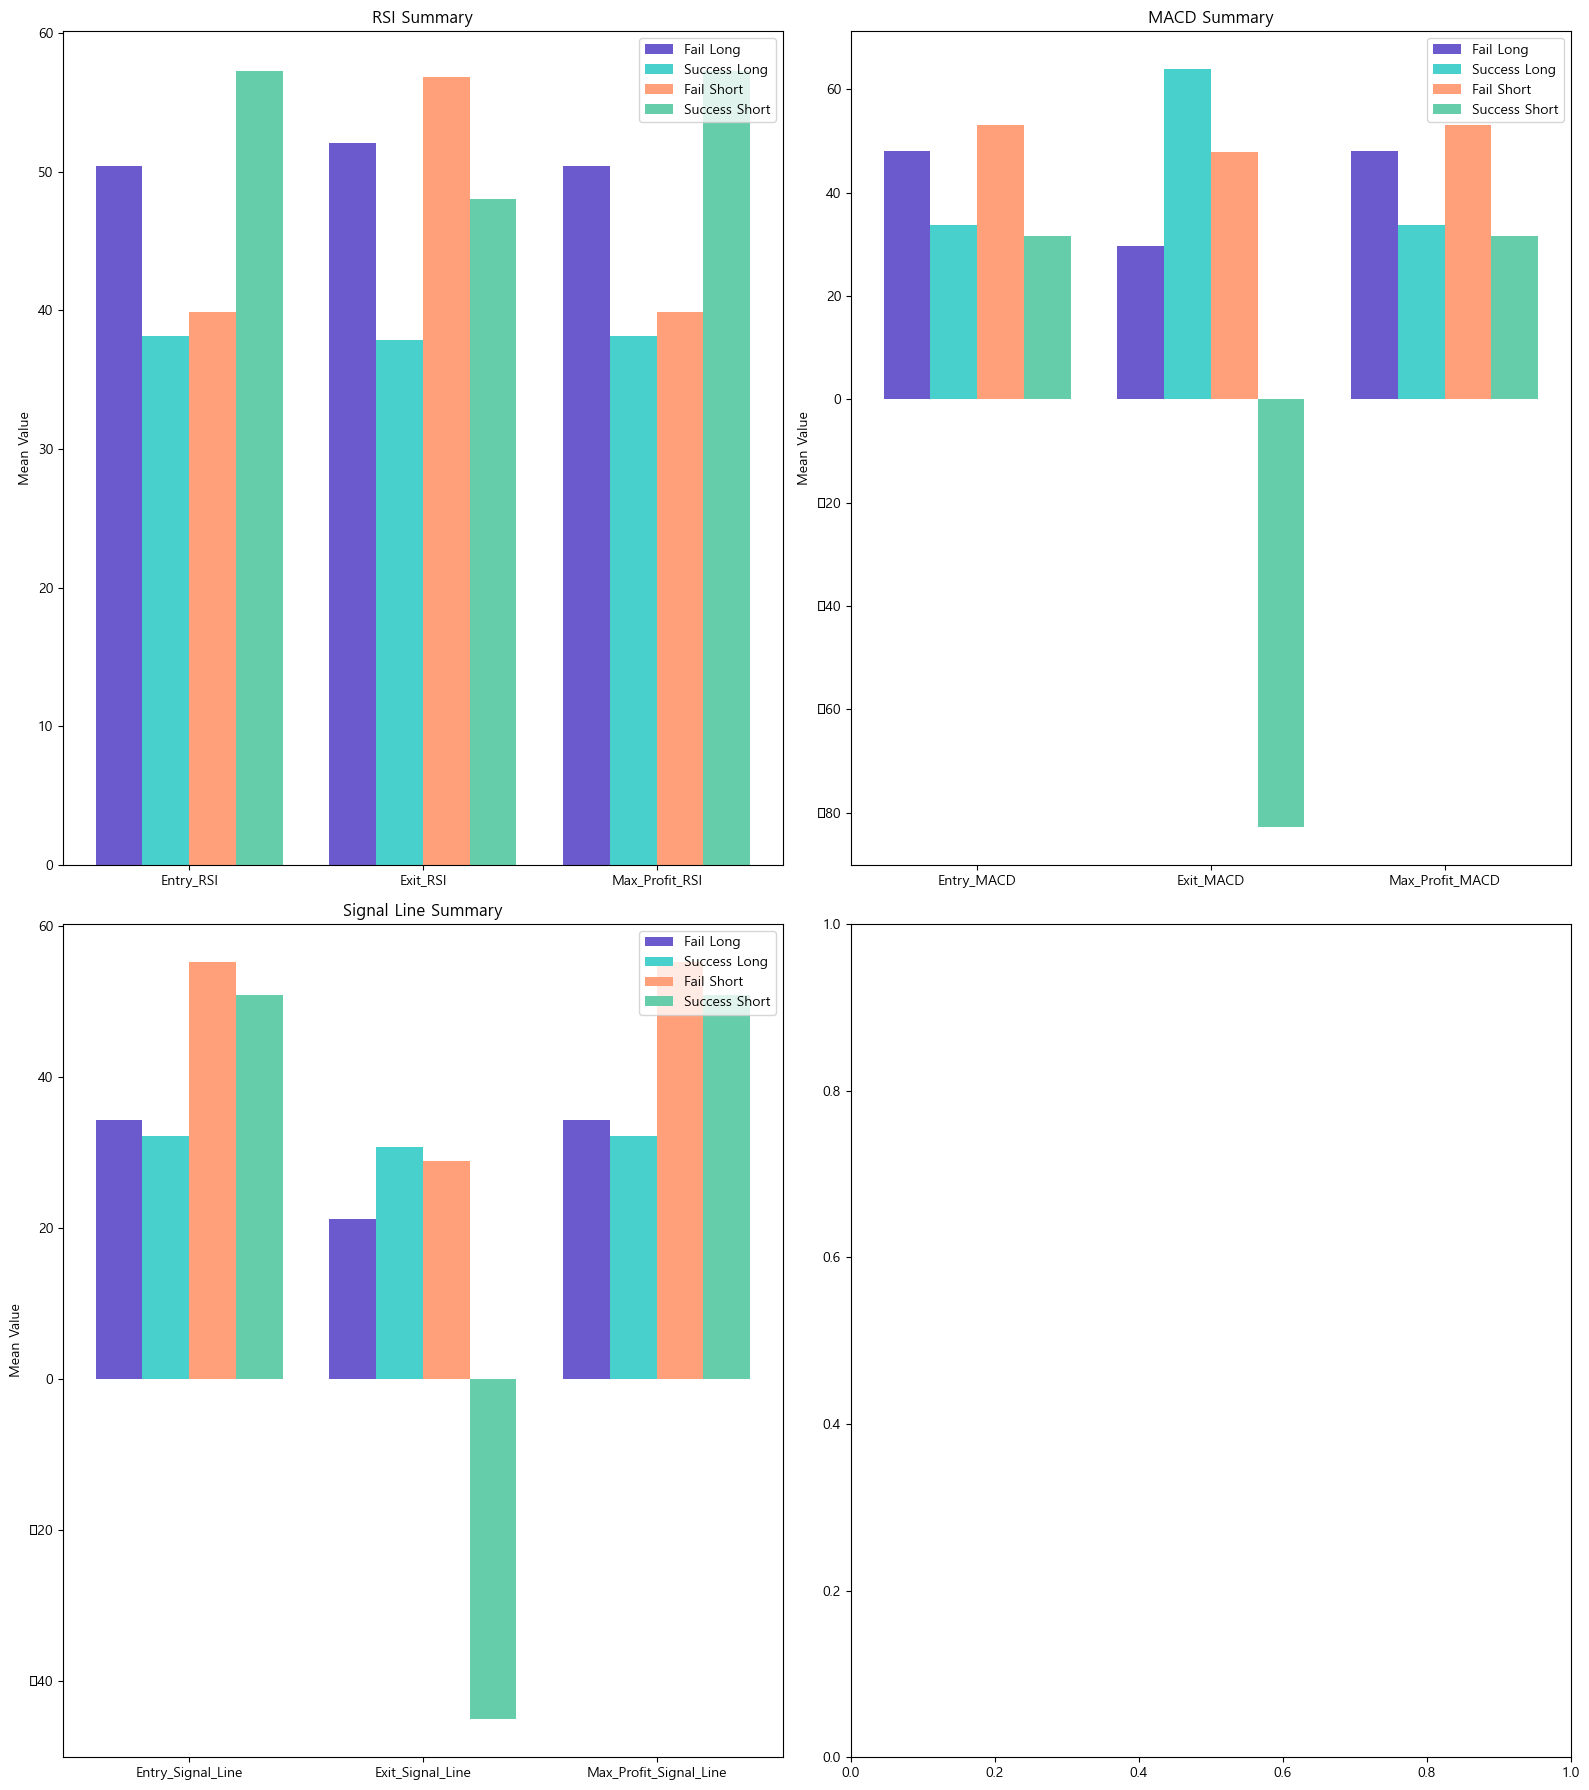

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# 성공과 실패, 롱과 숏에 대한 describe 데이터 가져오기
fail_long_desc = backtest_long.query(f"{check_value} < 0").describe()
success_long_desc = backtest_long.query(f"{check_value} > 0").describe()
fail_short_desc = backtest_short.query(f"{check_value} < 0").describe()
success_short_desc = backtest_short.query(f"{check_value} > 0").describe()

# 그래프 크기 설정
fig, axes = plt.subplots(2, 2, figsize=(16, 18))

# 각 지표별로 컬럼 묶음
rsi_columns = ['Entry_RSI', 'Exit_RSI', 'Max_Profit_RSI']
macd_columns = ['Entry_MACD', 'Exit_MACD', 'Max_Profit_MACD']
signal_columns = ['Entry_Signal_Line', 'Exit_Signal_Line', 'Max_Profit_Signal_Line']
bollinger_columns = ['Entry_Bollinger_Percentage', 'Exit_Bollinger_Percentage', 'Max_Profit_Bollinger_Percentage']

# 컬러 설정
colors = ['#6a5acd', '#48d1cc', '#ffa07a', '#66cdaa']  # 눈에 편한 색상들
bar_width = 0.2

# RSI 데이터 시각화
x = np.arange(len(rsi_columns))

axes[0, 0].bar(x - bar_width*1.5, fail_long_desc.loc['mean', rsi_columns], width=bar_width, color=colors[0], label='Fail Long')
axes[0, 0].bar(x - bar_width*0.5, success_long_desc.loc['mean', rsi_columns], width=bar_width, color=colors[1], label='Success Long')
axes[0, 0].bar(x + bar_width*0.5, fail_short_desc.loc['mean', rsi_columns], width=bar_width, color=colors[2], label='Fail Short')
axes[0, 0].bar(x + bar_width*1.5, success_short_desc.loc['mean', rsi_columns], width=bar_width, color=colors[3], label='Success Short')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(rsi_columns)
axes[0, 0].set_title("RSI Summary")
axes[0, 0].set_ylabel("Mean Value")
axes[0, 0].legend(loc='upper right')

# MACD 데이터 시각화
x = np.arange(len(macd_columns))
axes[0, 1].bar(x - bar_width*1.5, fail_long_desc.loc['mean', macd_columns], width=bar_width, color=colors[0], label='Fail Long')
axes[0, 1].bar(x - bar_width*0.5, success_long_desc.loc['mean', macd_columns], width=bar_width, color=colors[1], label='Success Long')
axes[0, 1].bar(x + bar_width*0.5, fail_short_desc.loc['mean', macd_columns], width=bar_width, color=colors[2], label='Fail Short')
axes[0, 1].bar(x + bar_width*1.5, success_short_desc.loc['mean', macd_columns], width=bar_width, color=colors[3], label='Success Short')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(macd_columns)
axes[0, 1].set_title("MACD Summary")
axes[0, 1].set_ylabel("Mean Value")
axes[0, 1].legend(loc='upper right')

# Signal Line 데이터 시각화
x = np.arange(len(signal_columns))
axes[1, 0].bar(x - bar_width*1.5, fail_long_desc.loc['mean', signal_columns], width=bar_width, color=colors[0], label='Fail Long')
axes[1, 0].bar(x - bar_width*0.5, success_long_desc.loc['mean', signal_columns], width=bar_width, color=colors[1], label='Success Long')
axes[1, 0].bar(x + bar_width*0.5, fail_short_desc.loc['mean', signal_columns], width=bar_width, color=colors[2], label='Fail Short')
axes[1, 0].bar(x + bar_width*1.5, success_short_desc.loc['mean', signal_columns], width=bar_width, color=colors[3], label='Success Short')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(signal_columns)
axes[1, 0].set_title("Signal Line Summary")
axes[1, 0].set_ylabel("Mean Value")
axes[1, 0].legend(loc='upper right')

# Bollinger Percentage 데이터 시각화
# x = np.arange(len(bollinger_columns))
# axes[1, 1].bar(x - bar_width*1.5, fail_long_desc.loc['mean', bollinger_columns], width=bar_width, color=colors[0], label='Fail Long')
# axes[1, 1].bar(x - bar_width*0.5, success_long_desc.loc['mean', bollinger_columns], width=bar_width, color=colors[1], label='Success Long')
# axes[1, 1].bar(x + bar_width*0.5, fail_short_desc.loc['mean', bollinger_columns], width=bar_width, color=colors[2], label='Fail Short')
# axes[1, 1].bar(x + bar_width*1.5, success_short_desc.loc['mean', bollinger_columns], width=bar_width, color=colors[3], label='Success Short')
# axes[1, 1].set_xticks(x)
# axes[1, 1].set_xticklabels(bollinger_columns)
# axes[1, 1].set_title("Bollinger Percentage Summary")
# axes[1, 1].set_ylabel("Mean Value")
# axes[1, 1].legend(loc='upper right')

# 레이아웃 조정
plt.tight_layout()
plt.show()


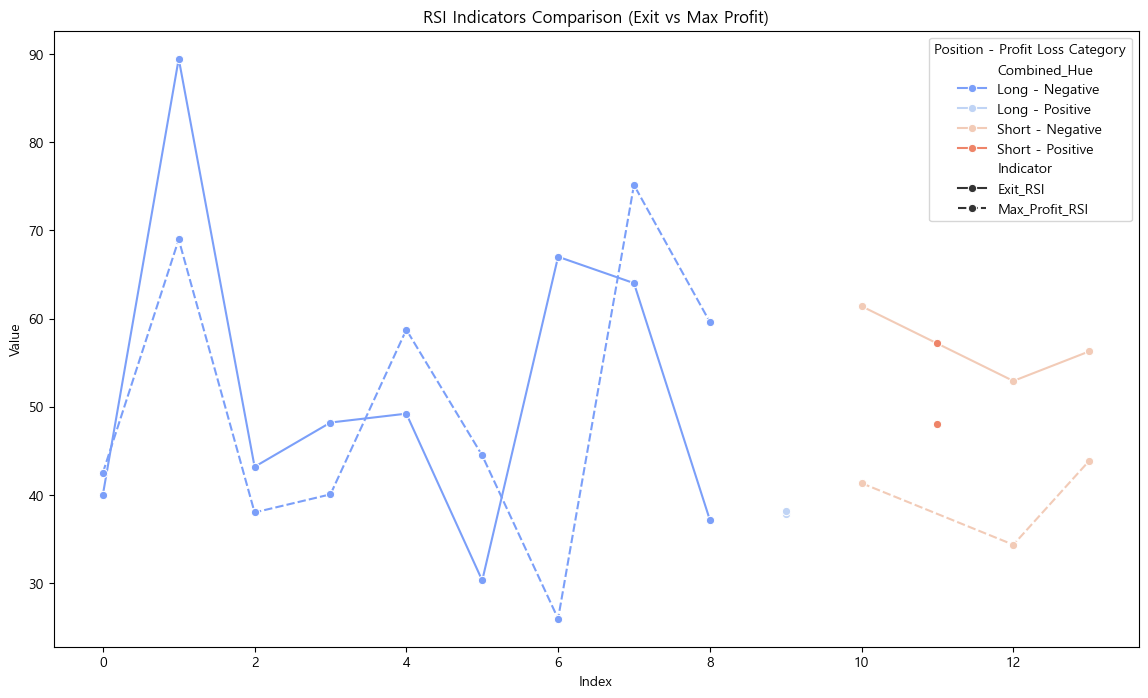

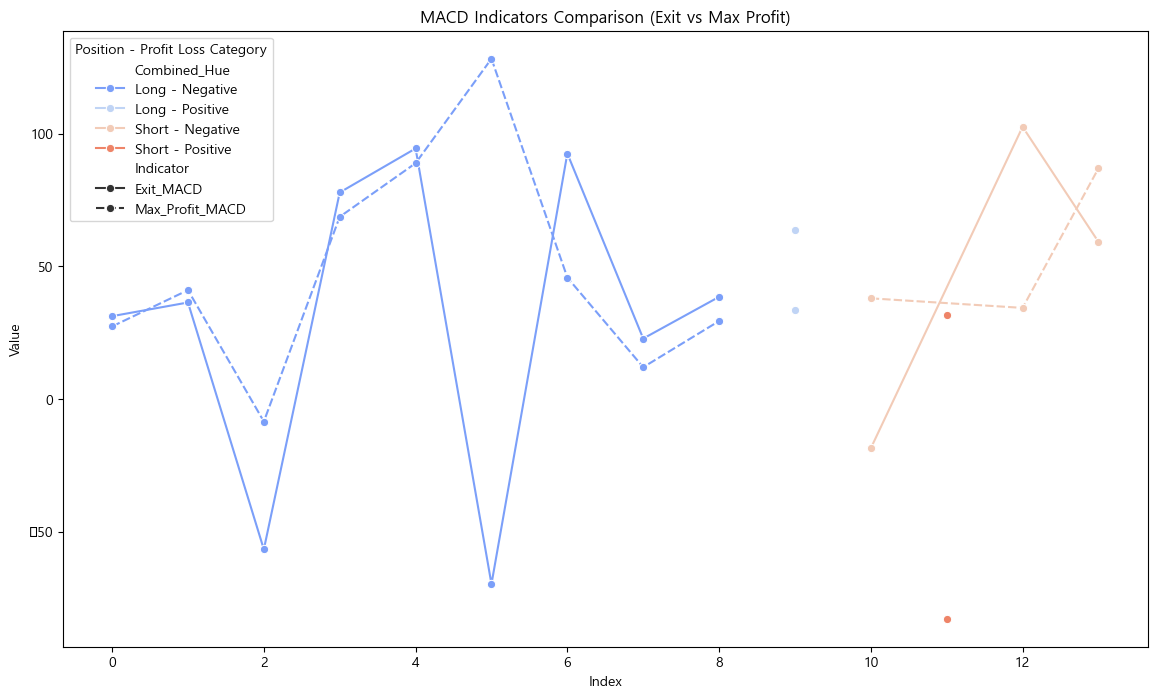

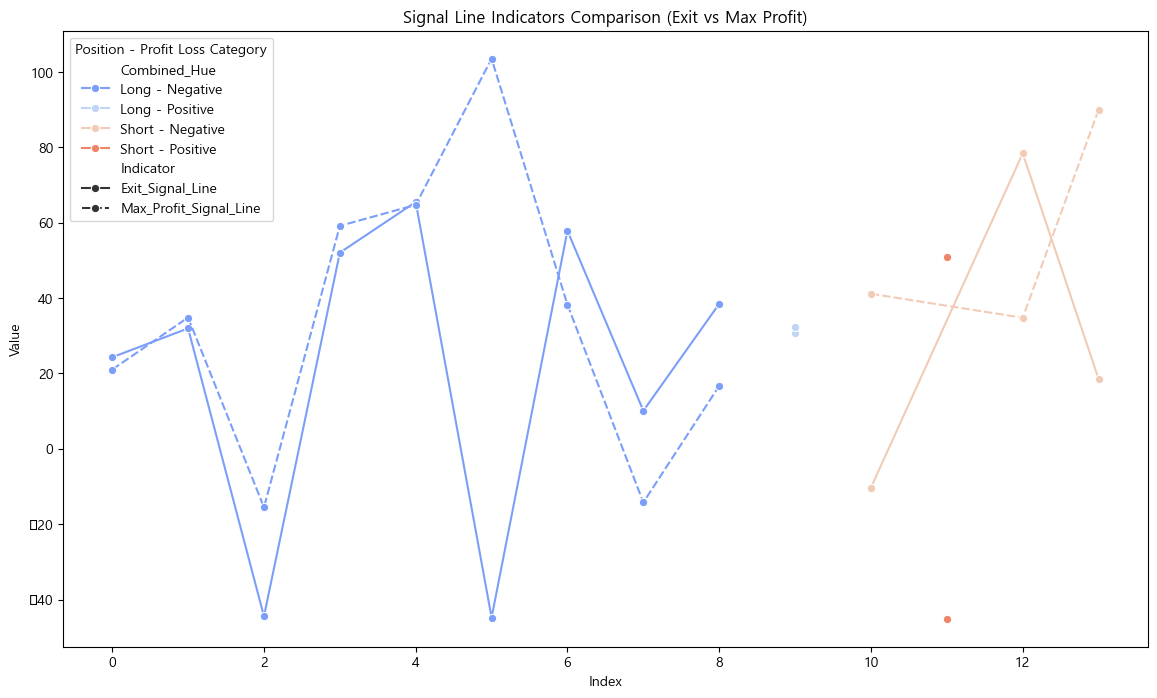

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming you have combined_data from backtest_long and backtest_short data
combined_data = pd.concat([backtest_long, backtest_short])

# Define indicator groups
exit_indicators = ["Exit_RSI", "Exit_MACD", "Exit_Signal_Line"]
# exit_indicators = ["Exit_RSI", "Exit_MACD", "Exit_Signal_Line", "Exit_Bollinger_Percentage"]
# max_profit_indicators = ["Max_Profit_RSI", "Max_Profit_MACD", "Max_Profit_Signal_Line", "Max_Profit_Bollinger_Percentage"]
max_profit_indicators = ["Max_Profit_RSI", "Max_Profit_MACD", "Max_Profit_Signal_Line"]

# Melt the data
plot_data = combined_data.melt(id_vars=["Position", f"{check_value}"], 
                               value_vars=exit_indicators + max_profit_indicators,
                               var_name="Indicator", value_name="Value")

# Create a combined hue for Position and Profit_Loss
plot_data["Profit_Loss_Category"] = plot_data[f"{check_value}"].apply(lambda x: "Positive" if x > 0 else "Negative")
plot_data["Combined_Hue"] = plot_data["Position"] + " - " + plot_data["Profit_Loss_Category"]

# Add a numeric index column for x-axis, grouped by each Indicator
plot_data["Index"] = plot_data.groupby("Indicator").cumcount()

# Plot RSI indicators
plt.figure(figsize=(14, 8))
sns.lineplot(data=plot_data[plot_data["Indicator"].isin(["Exit_RSI", "Max_Profit_RSI"])],
             x="Index", y="Value", hue="Combined_Hue", style="Indicator", marker="o", palette="coolwarm")
plt.title("RSI Indicators Comparison (Exit vs Max Profit)")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend(title="Position - Profit Loss Category")
plt.show()

# Plot MACD indicators
plt.figure(figsize=(14, 8))
sns.lineplot(data=plot_data[plot_data["Indicator"].isin(["Exit_MACD", "Max_Profit_MACD"])],
             x="Index", y="Value", hue="Combined_Hue", style="Indicator", marker="o", palette="coolwarm")
plt.title("MACD Indicators Comparison (Exit vs Max Profit)")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend(title="Position - Profit Loss Category")
plt.show()

# Plot Signal Line indicators
plt.figure(figsize=(14, 8))
sns.lineplot(data=plot_data[plot_data["Indicator"].isin(["Exit_Signal_Line", "Max_Profit_Signal_Line"])],
             x="Index", y="Value", hue="Combined_Hue", style="Indicator", marker="o", palette="coolwarm")
plt.title("Signal Line Indicators Comparison (Exit vs Max Profit)")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend(title="Position - Profit Loss Category")
plt.show()

# Plot Bollinger Percentage indicators
# plt.figure(figsize=(14, 8))
# sns.lineplot(data=plot_data[plot_data["Indicator"].isin(["Exit_Bollinger_Percentage", "Max_Profit_Bollinger_Percentage"])],
#              x="Index", y="Value", hue="Combined_Hue", style="Indicator", marker="o", palette="coolwarm")
# plt.title("Bollinger Percentage Indicators Comparison (Exit vs Max Profit)")
# plt.xlabel("Index")
# plt.ylabel("Value")
# plt.legend(title="Position - Profit Loss Category")
# plt.show()


KeyError: 'Bollinger_Percentage'

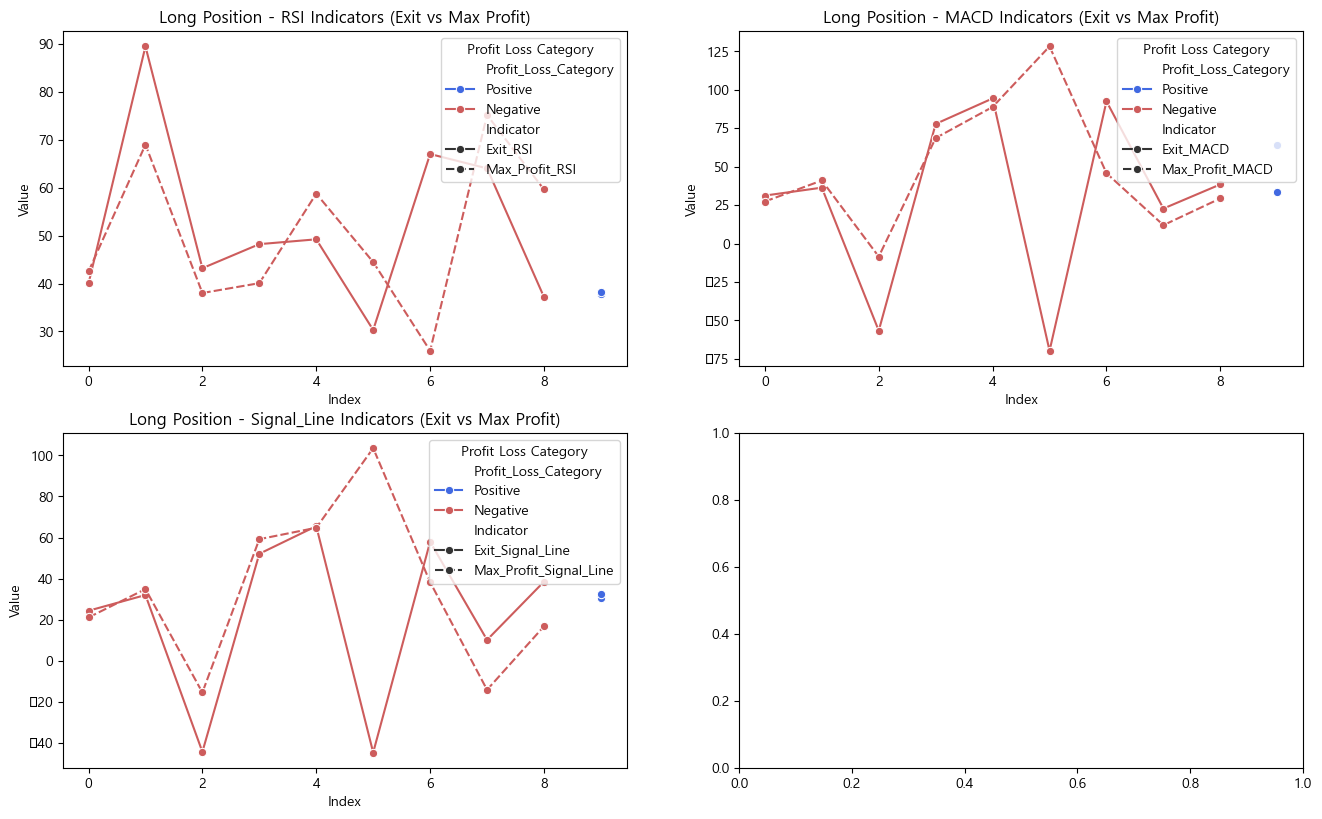

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming combined_data is your concatenated dataframe of backtest_long and backtest_short
# combined_data = pd.concat([backtest_long, backtest_short])

# Define indicator groups
# exit_indicators = ["Exit_RSI", "Exit_MACD", "Exit_Signal_Line", "Exit_Bollinger_Percentage"]
exit_indicators = ["Exit_RSI", "Exit_MACD", "Exit_Signal_Line"]
# max_profit_indicators = ["Max_Profit_RSI", "Max_Profit_MACD", "Max_Profit_Signal_Line", "Max_Profit_Bollinger_Percentage"]
max_profit_indicators = ["Max_Profit_RSI", "Max_Profit_MACD", "Max_Profit_Signal_Line"]

# Melt the data
plot_data = combined_data.melt(id_vars=["Position", f"{check_value}"], 
                               value_vars=exit_indicators + max_profit_indicators,
                               var_name="Indicator", value_name="Value")

# Create a combined hue for Profit_Loss
plot_data["Profit_Loss_Category"] = plot_data[f"{check_value}"].apply(lambda x: "Positive" if x > 0 else "Negative")

# Add a numeric index column for x-axis, grouped by each Indicator
plot_data["Index"] = plot_data.groupby("Indicator").cumcount()

# Plot setup for 8 graphs
plt.figure(figsize=(16, 20))
positions = ["Long", "Short"]
indicators = ["RSI", "MACD", "Signal_Line", "Bollinger_Percentage"]
indicator_pairs = {
    "RSI": ["Exit_RSI", "Max_Profit_RSI"],
    "MACD": ["Exit_MACD", "Max_Profit_MACD"],
    "Signal_Line": ["Exit_Signal_Line", "Max_Profit_Signal_Line"],
    # "Bollinger_Percentage": ["Exit_Bollinger_Percentage", "Max_Profit_Bollinger_Percentage"]
}

# Set palette for positive and negative categories
custom_palette = {"Positive": "royalblue", "Negative": "indianred"}

# Loop through positions and indicators
for pos_idx, pos in enumerate(positions):
    for ind_idx, ind in enumerate(indicators):
        plt.subplot(4, 2, pos_idx * 4 + ind_idx + 1)
        
        # Filter data based on Position and specific indicator pair
        data = plot_data[(plot_data["Position"] == pos) & 
                         (plot_data["Indicator"].isin(indicator_pairs[ind]))]
        
        # Create line plot for the filtered data
        sns.lineplot(data=data, x="Index", y="Value", 
                     hue="Profit_Loss_Category", style="Indicator", marker="o", 
                     hue_order=["Positive", "Negative"], palette=custom_palette)
        
        plt.title(f"{pos} Position - {ind} Indicators (Exit vs Max Profit)")
        plt.xlabel("Index")
        plt.ylabel("Value")
        plt.legend(title="Profit Loss Category", loc='upper right')

plt.tight_layout()
plt.show()


In [17]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# # Assuming combined_data is your concatenated dataframe of backtest_long and backtest_short
# # combined_data = pd.concat([backtest_long, backtest_short])

# # Define indicator groups for entry, exit, and max profit
# # entry_indicators = ["Entry_RSI", "Entry_MACD", "Entry_Signal_Line", "Entry_Bollinger_Percentage"]
# entry_indicators = ["Entry_RSI", "Entry_MACD", "Entry_Signal_Line"]


# # Melt the data to include entry indicators
# plot_data = combined_data.melt(id_vars=["Position", f"{check_value}"], 
#                                value_vars=entry_indicators,
#                                var_name="Indicator", value_name="Value")

# # Create a combined hue for Profit_Loss
# plot_data["Profit_Loss_Category"] = plot_data[f"{check_value}"].apply(lambda x: "Positive" if x > 0 else "Negative")

# # Add a numeric index column for x-axis, grouped by each Indicator
# plot_data["Index"] = plot_data.groupby("Indicator").cumcount()

# # Plot setup for 4 graphs (Long and Short positions separated for each indicator)
# plt.figure(figsize=(16, 20))
# positions = ["Long", "Short"]
# # indicators = ["RSI", "MACD", "Signal_Line", "Bollinger_Percentage"]
# indicators = ["RSI", "MACD", "Signal_Line"]

# indicator_pairs_entry = {
#     "RSI": ["Entry_RSI"],
#     "MACD": ["Entry_MACD"],
#     "Signal_Line": ["Entry_Signal_Line"],
#     # "Bollinger_Percentage": ["Entry_Bollinger_Percentage"]
# }

# # Loop through positions and entry indicators
# for pos_idx, pos in enumerate(positions):
#     for ind_idx, ind in enumerate(indicators):
#         plt.subplot(4, 2, pos_idx * 4 + ind_idx + 1)
        
#         # Filter data based on Position and specific entry indicator
#         data = plot_data[(plot_data["Position"] == pos) & 
#                          (plot_data["Indicator"].isin(indicator_pairs_entry[ind]))]
        
#         # Create line plot for the filtered data
#         sns.lineplot(data=data, x="Index", y="Value", 
#                      hue="Profit_Loss_Category", marker="o", palette="coolwarm")
#         plt.title(f"{pos} Position - {ind} Entry Indicator")
#         plt.xlabel("Index")
#         plt.ylabel("Value")
#         plt.legend(title="Profit Loss Category", loc='upper right')

# plt.tight_layout()
# plt.show()


KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['Entry_Bollinger_Percentage']"

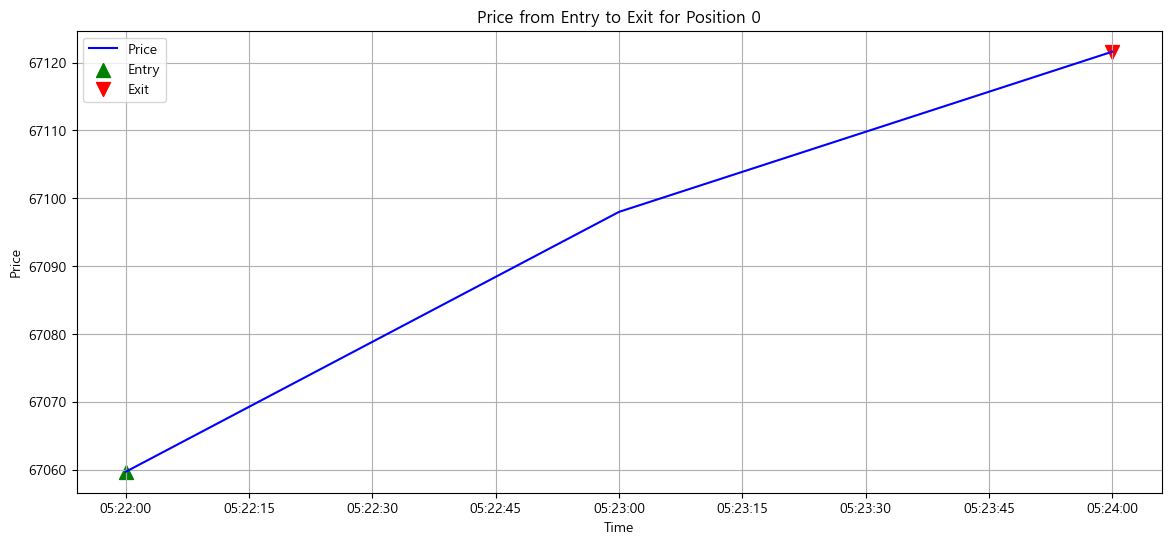

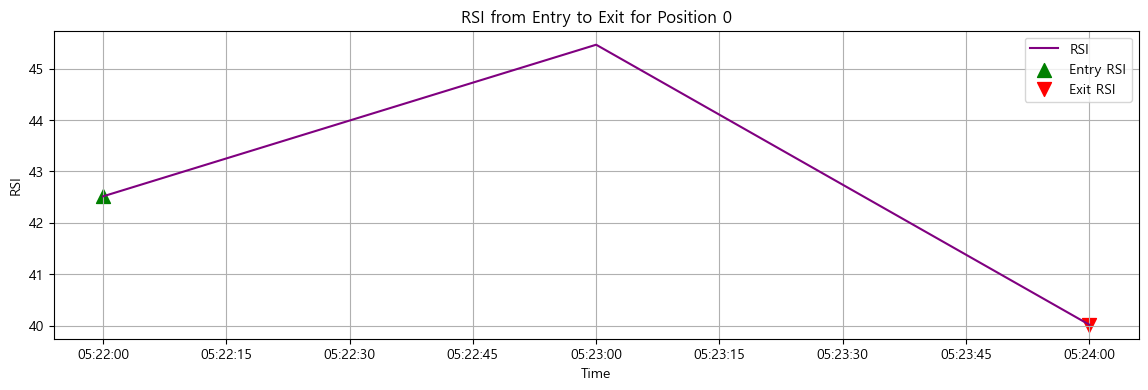

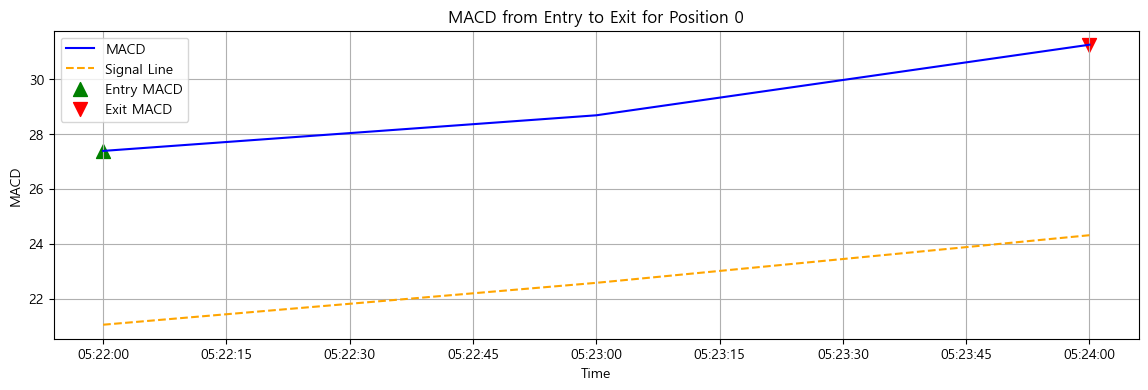

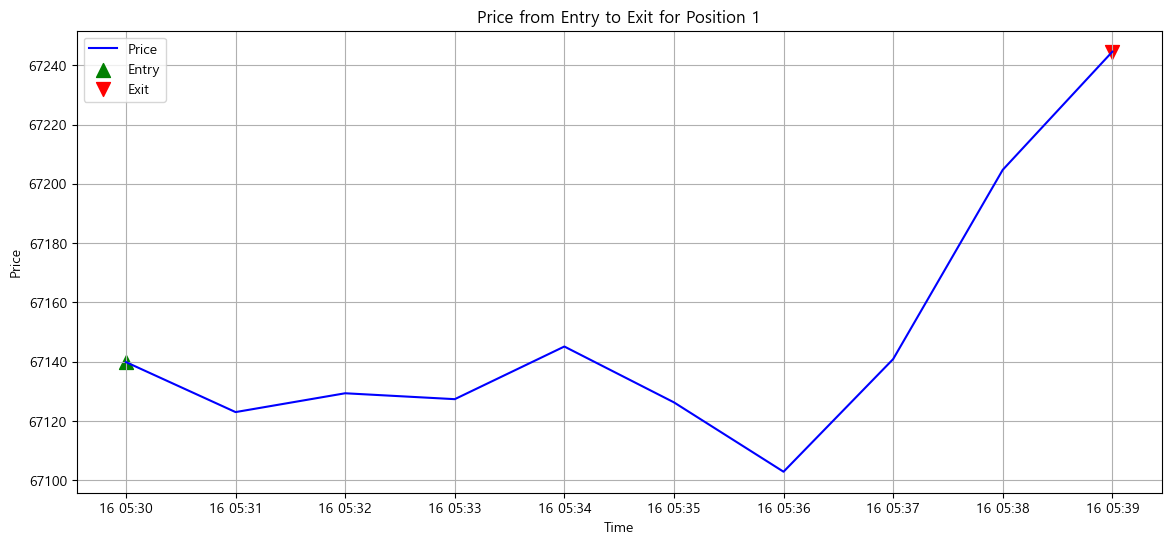

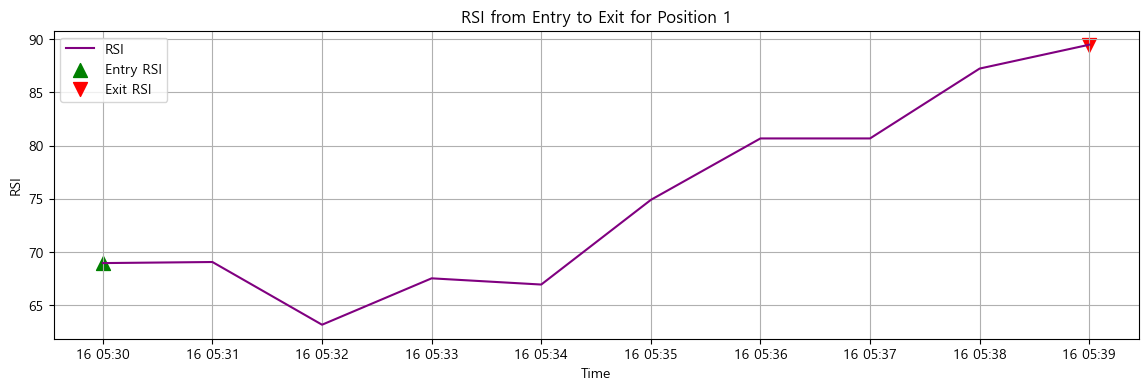

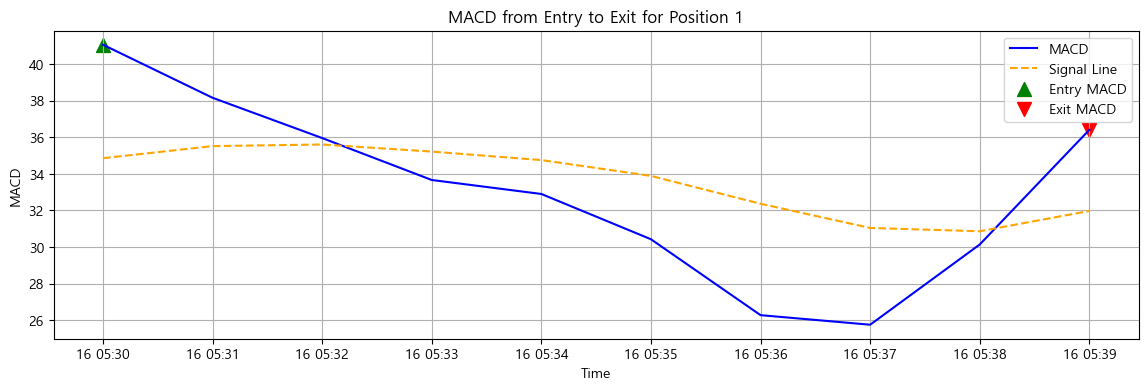

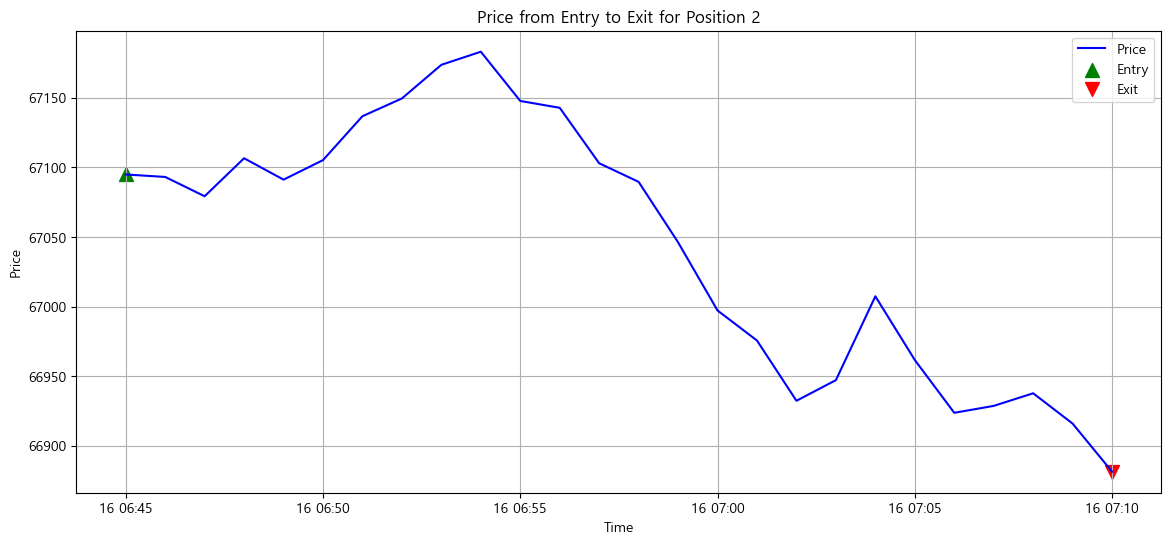

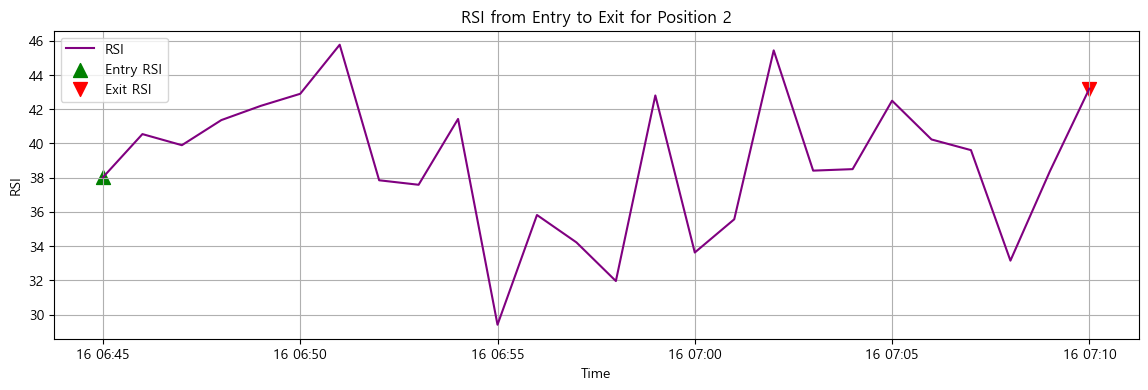

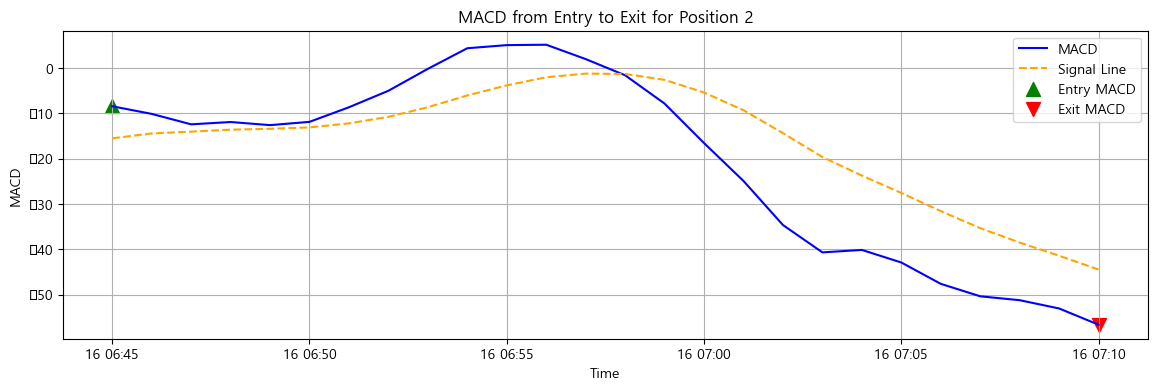

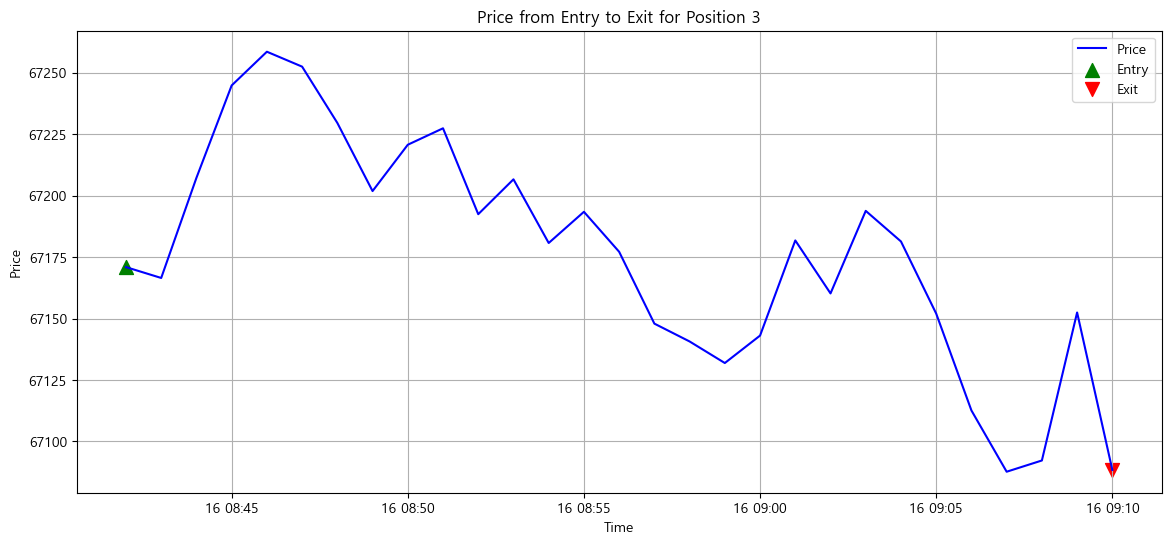

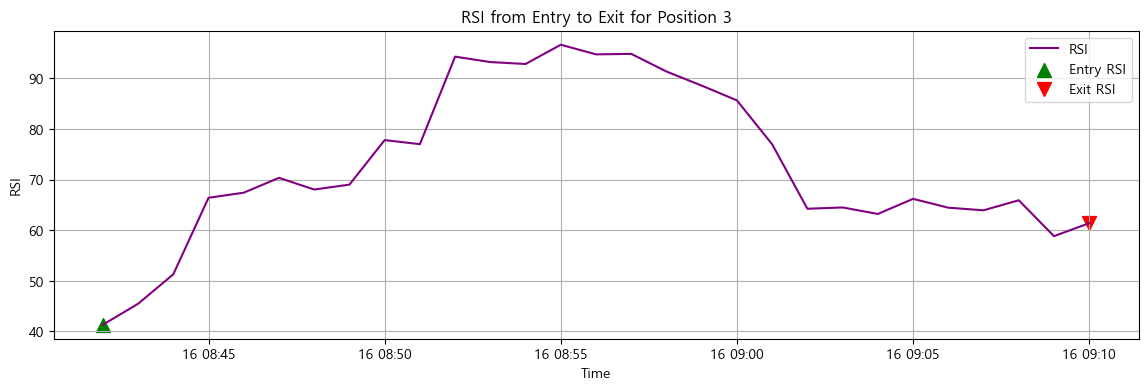

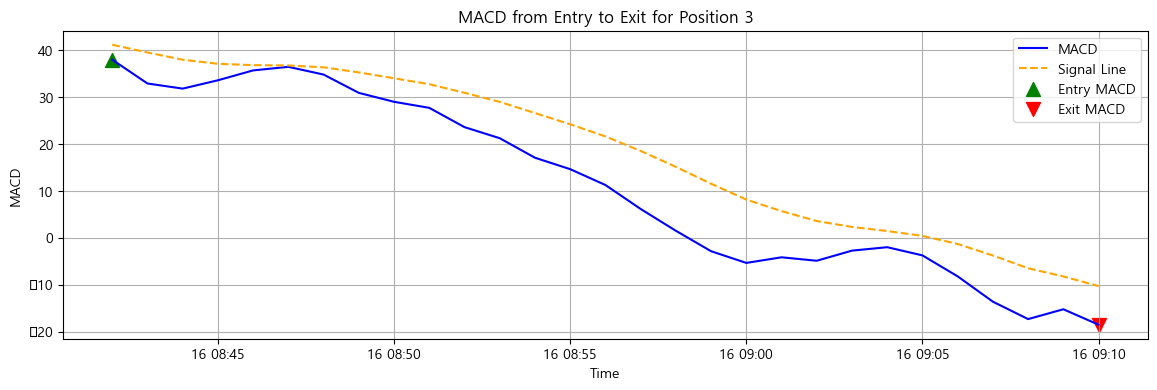

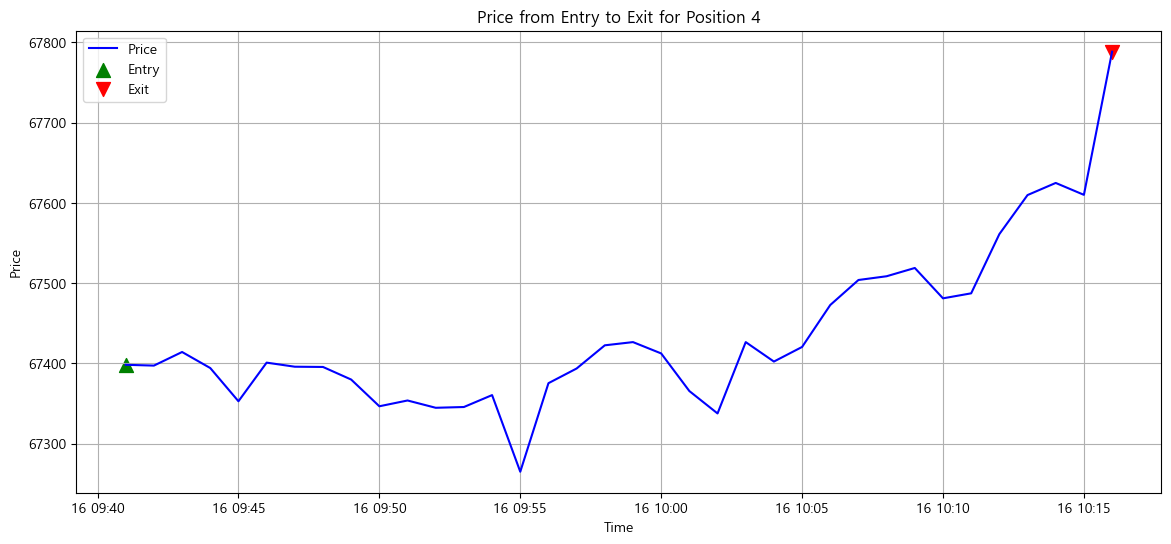

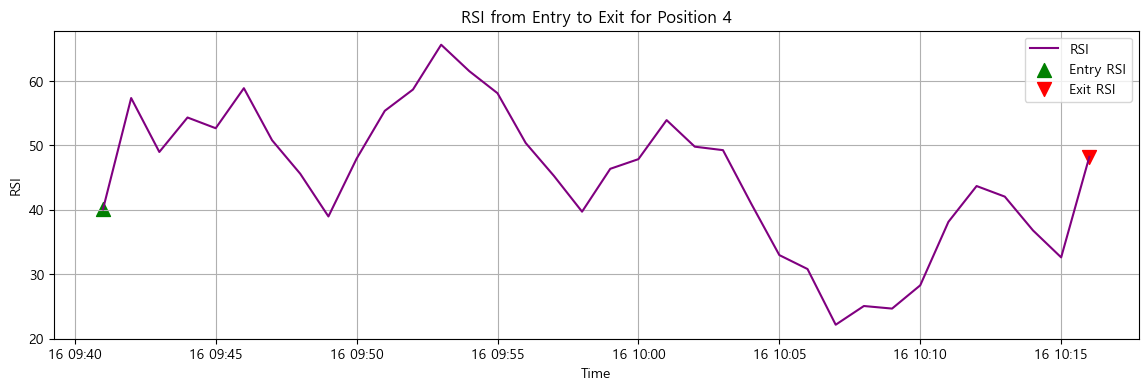

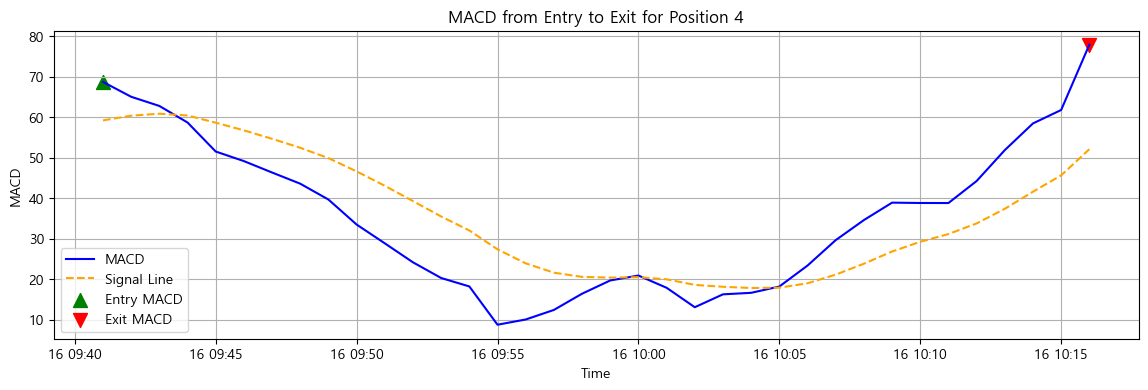

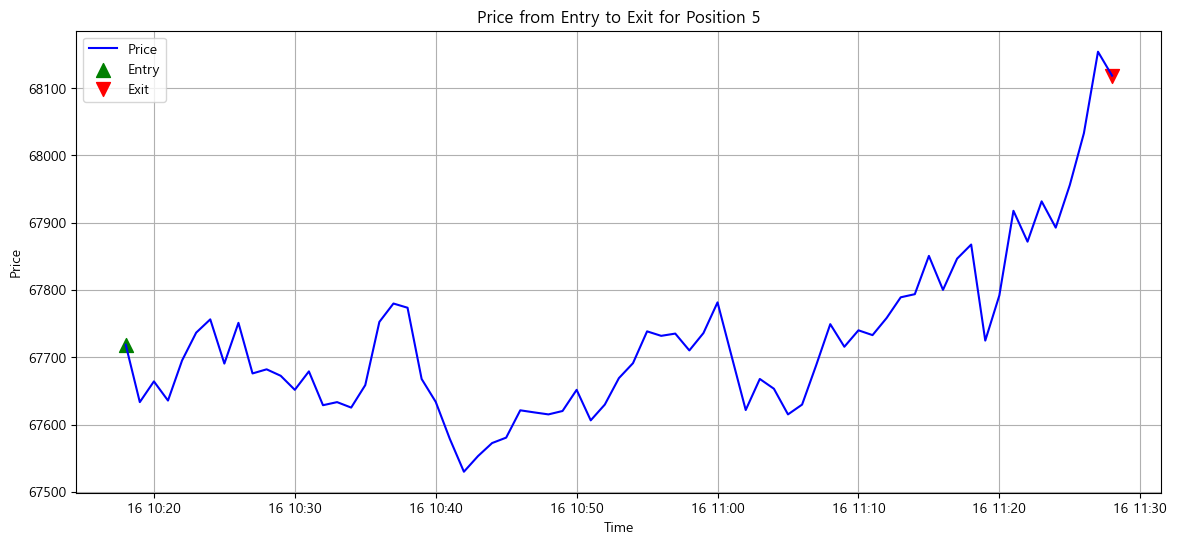

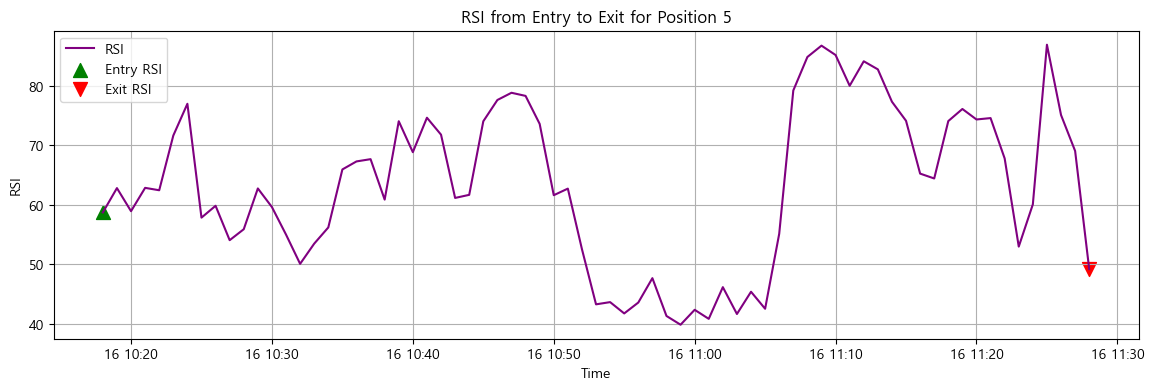

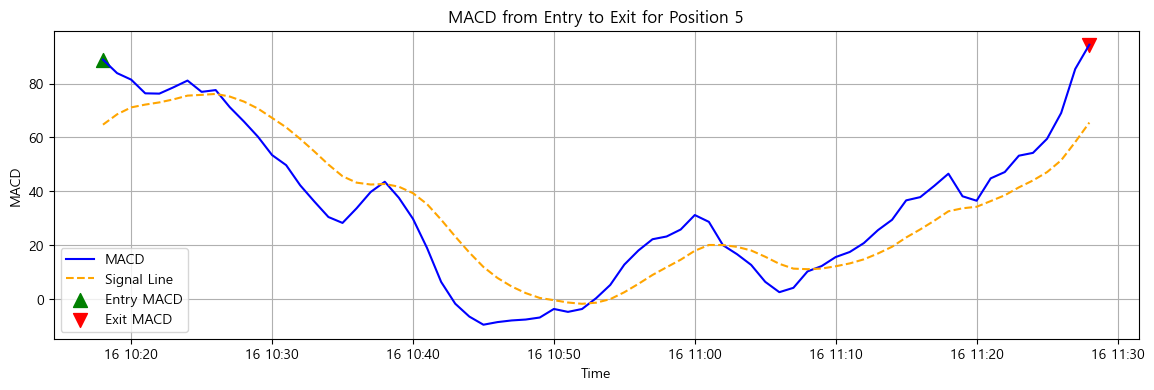

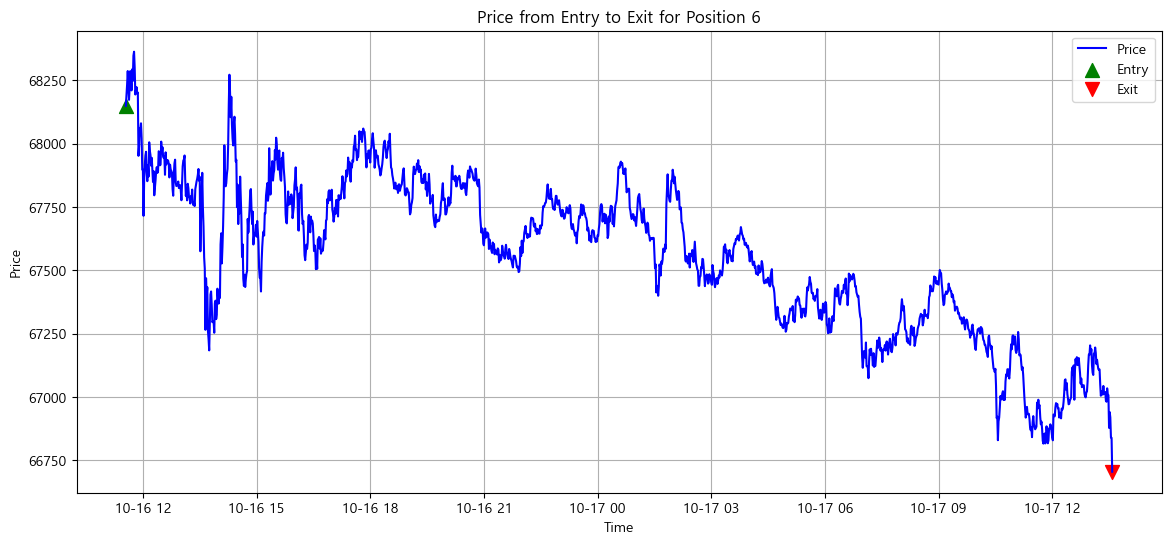

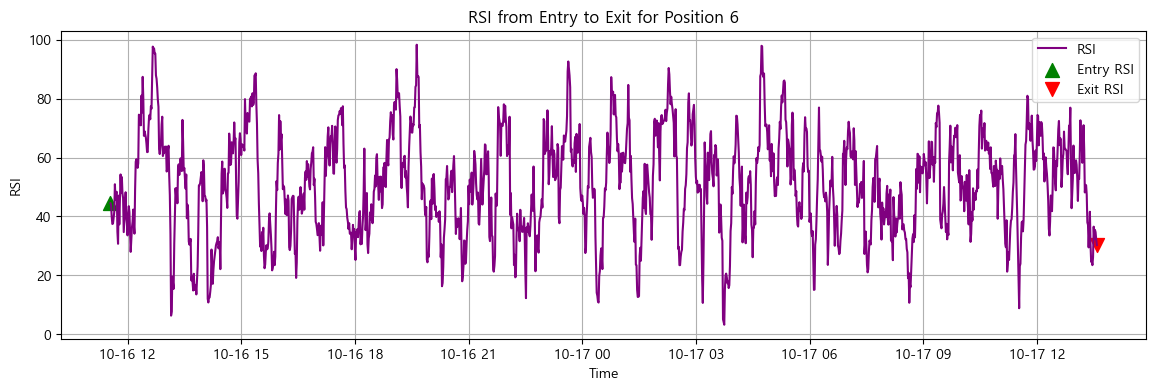

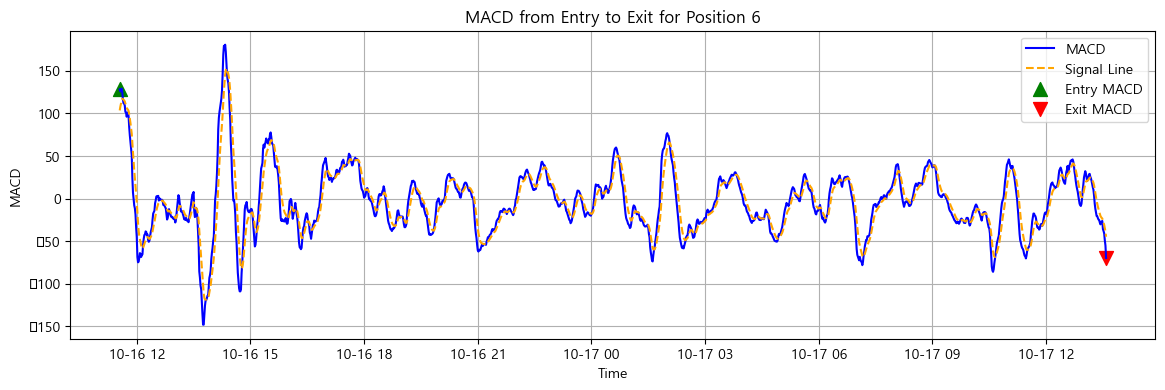

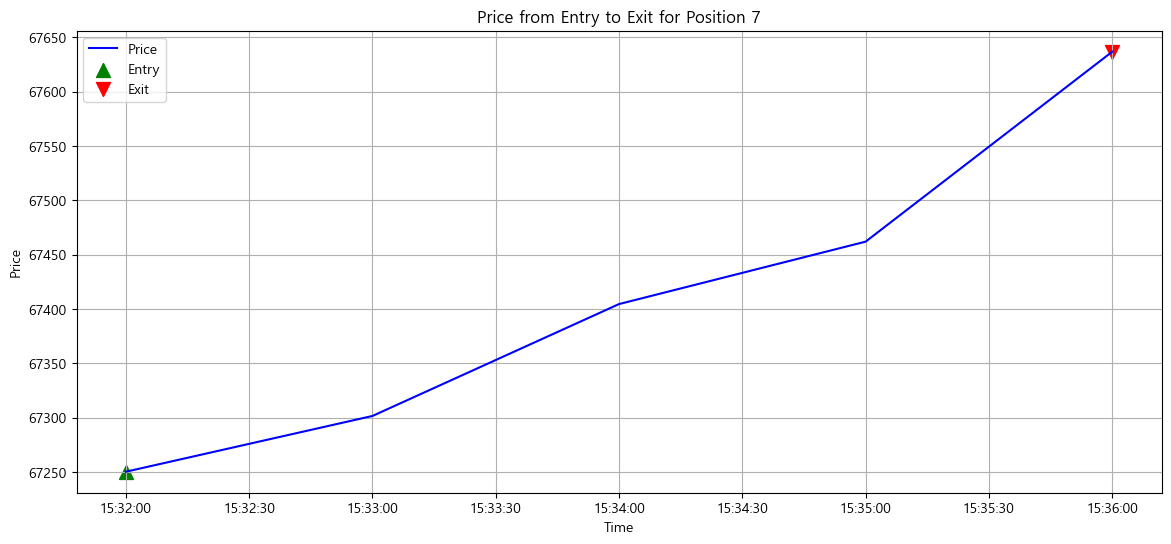

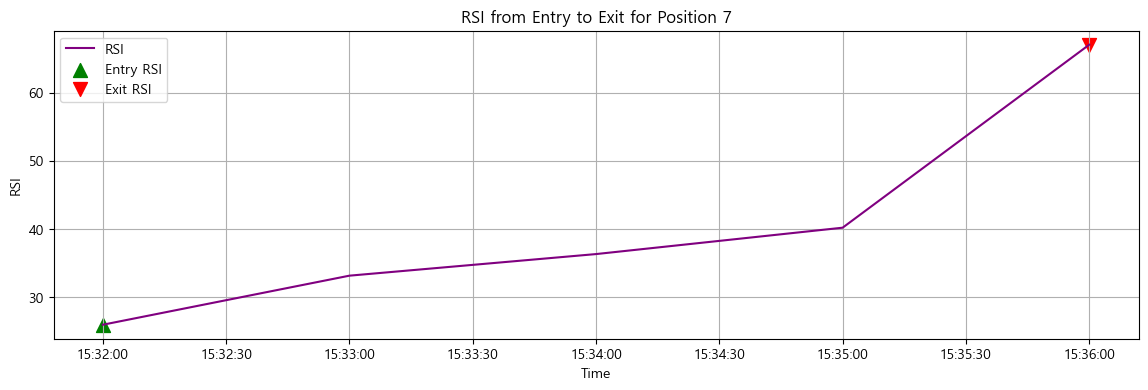

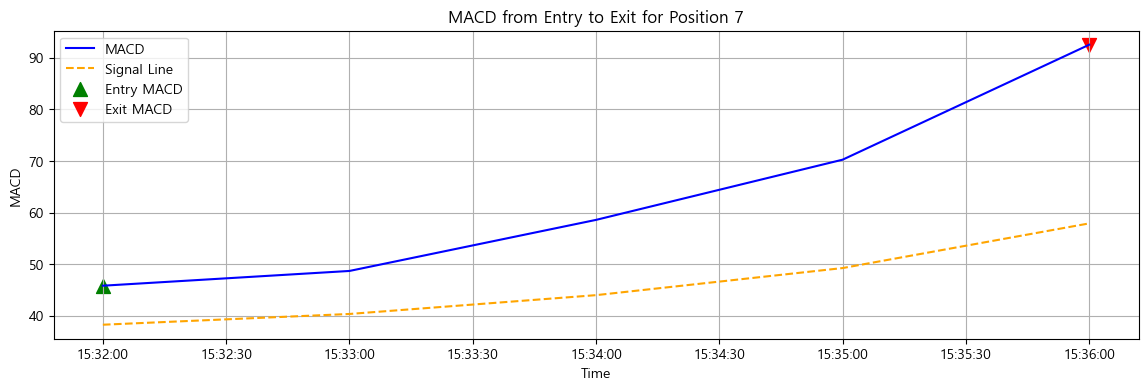

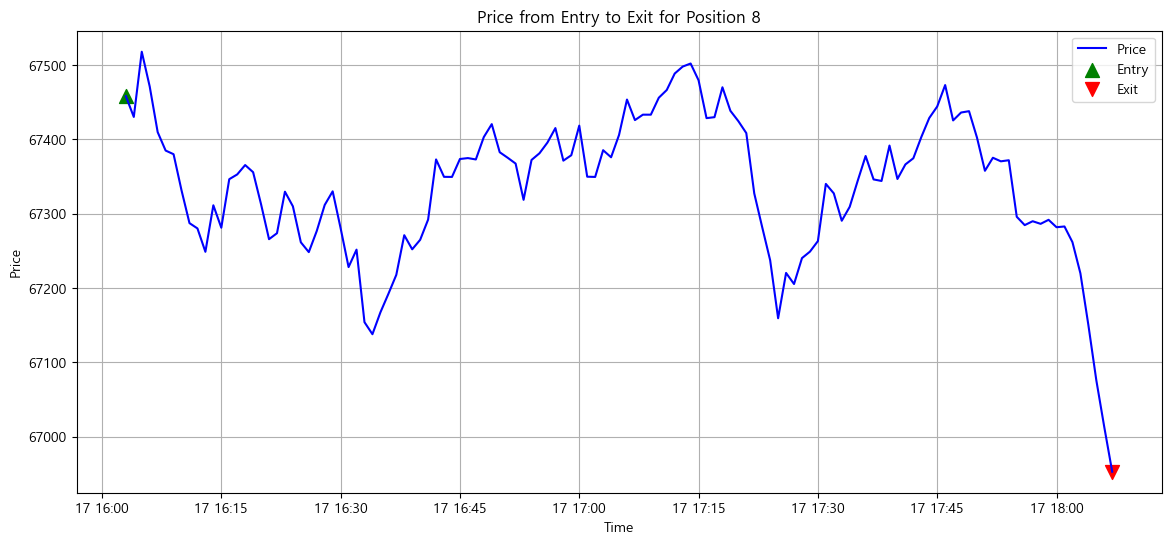

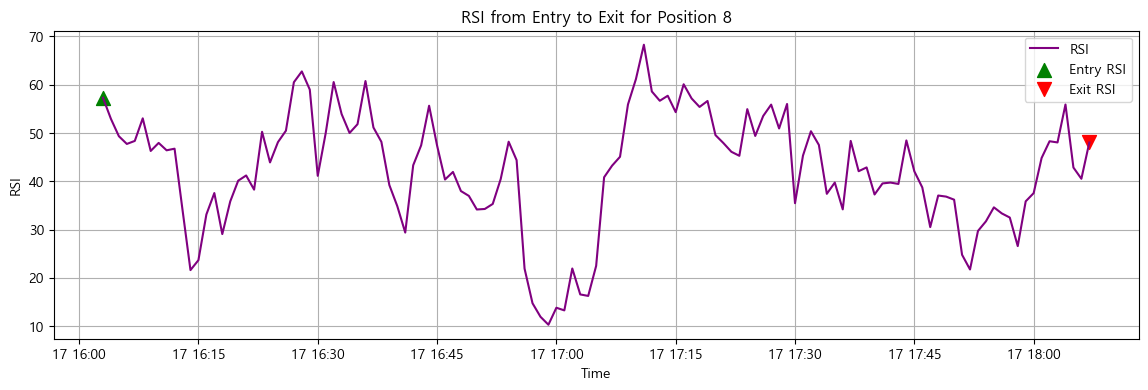

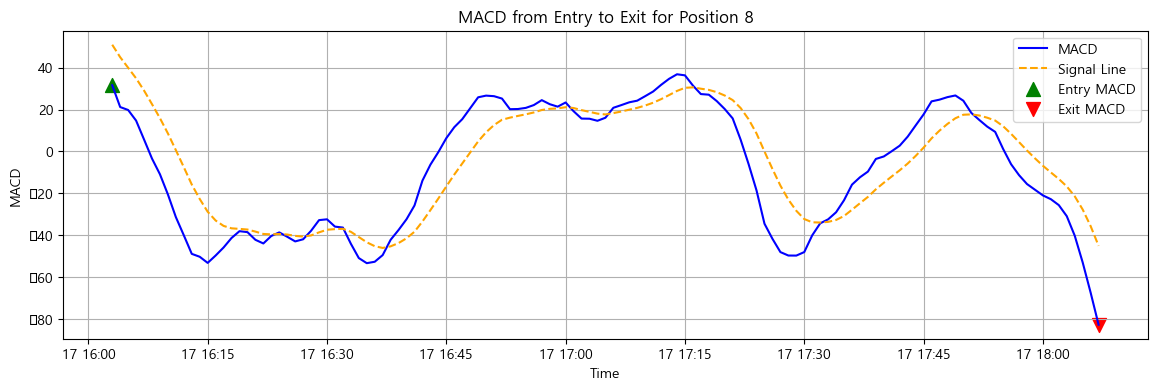

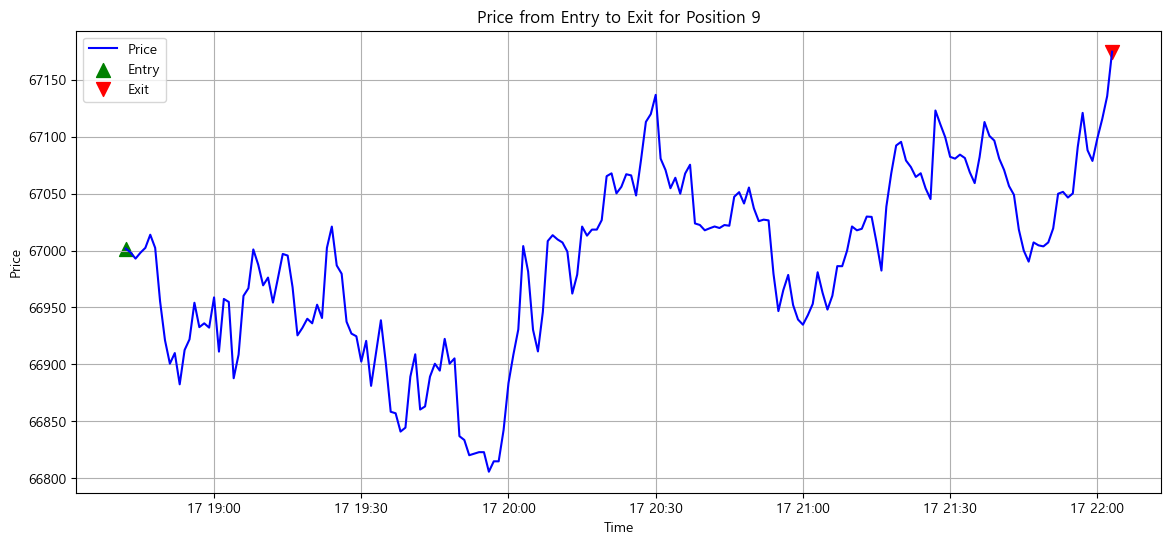

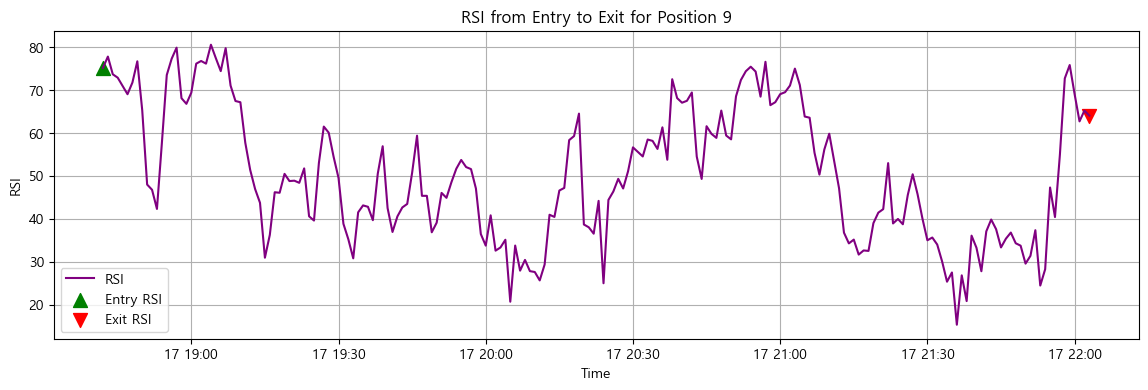

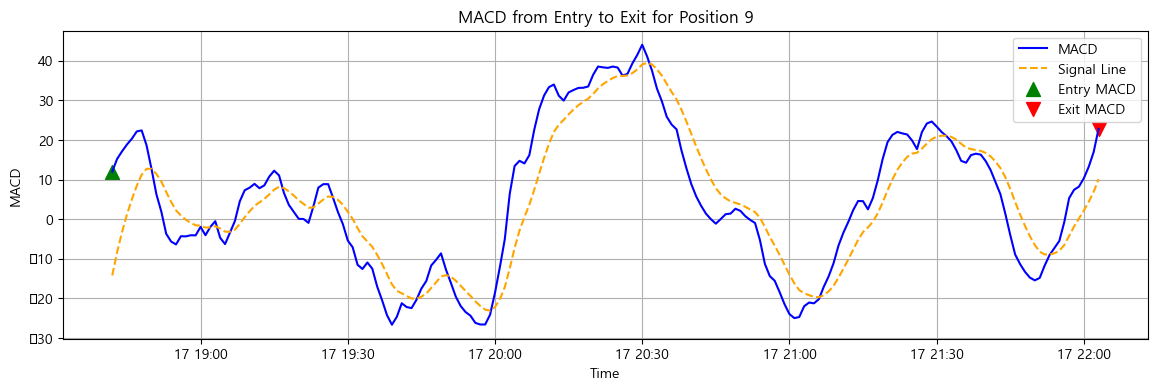

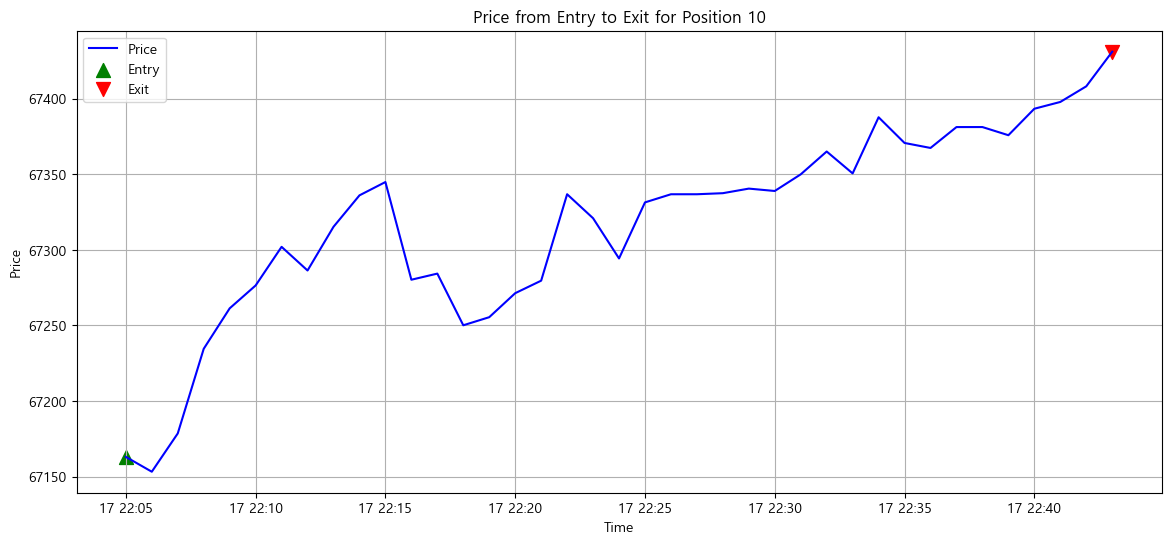

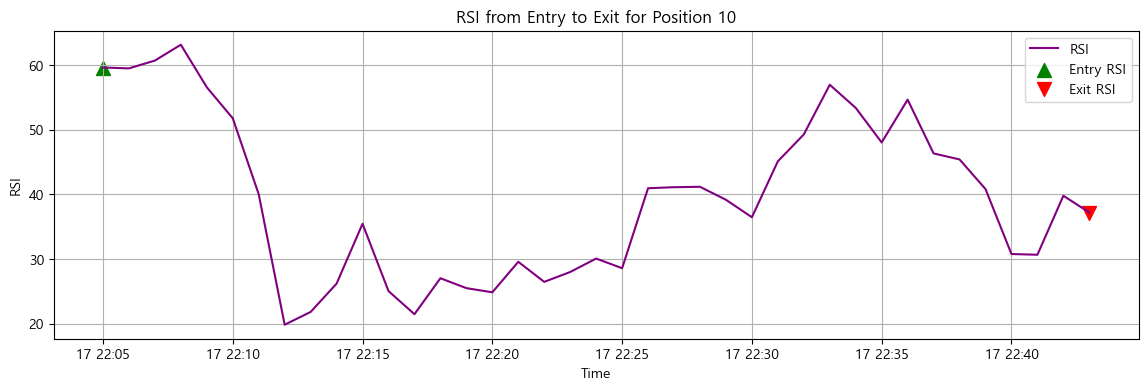

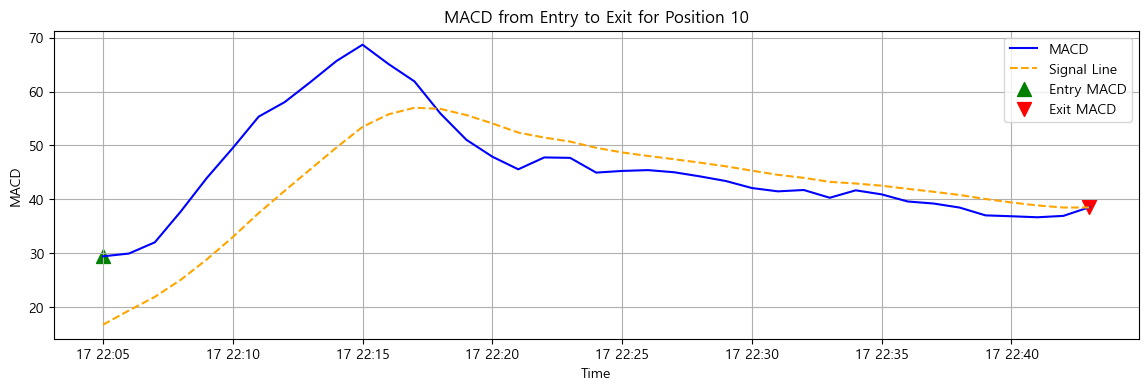

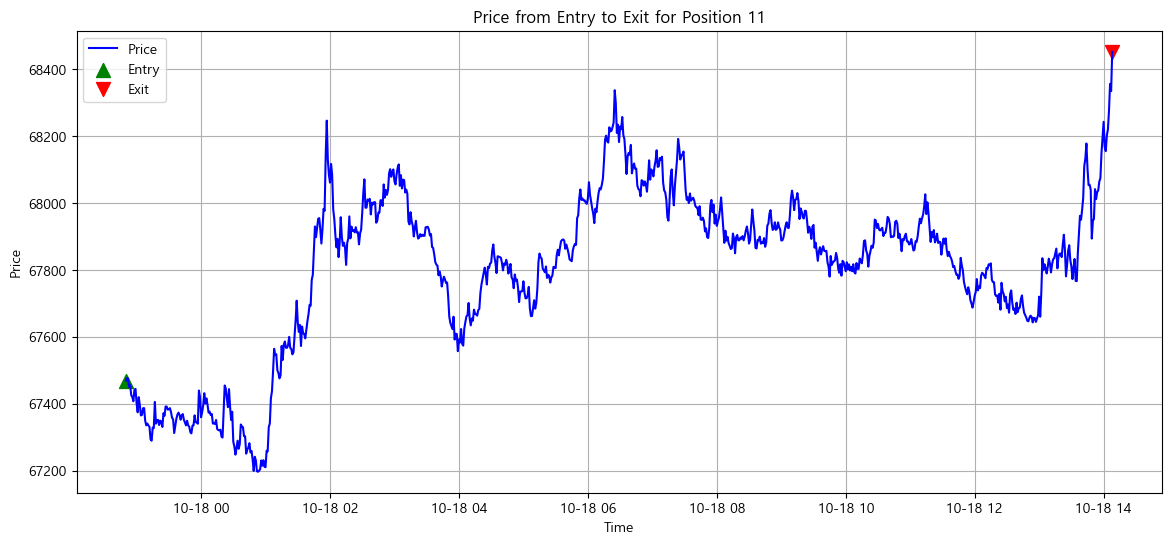

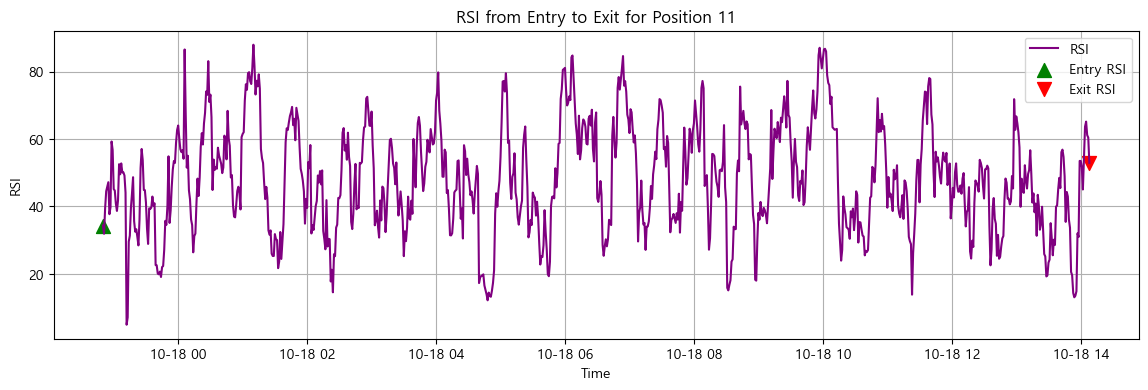

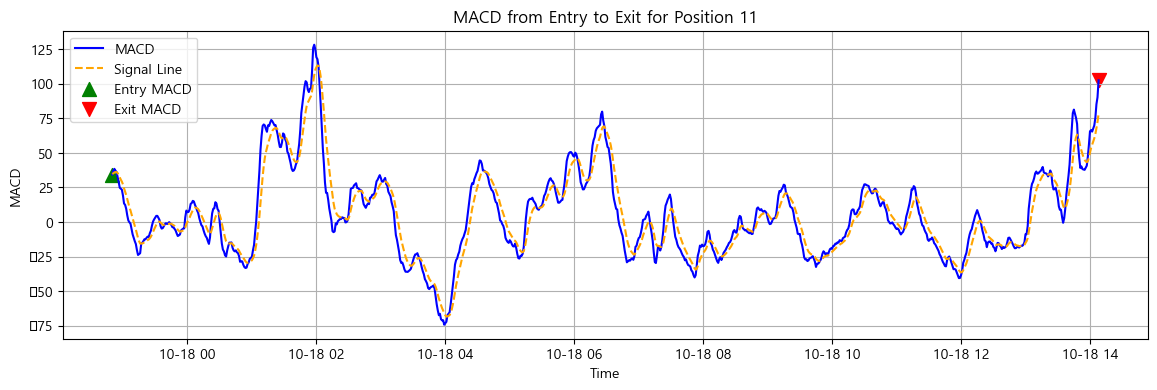

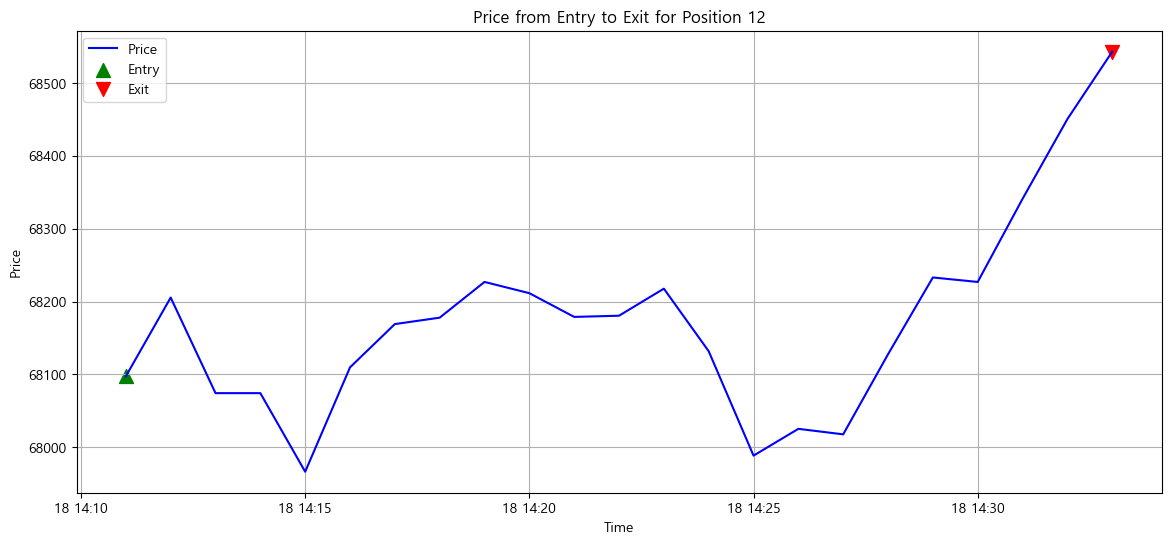

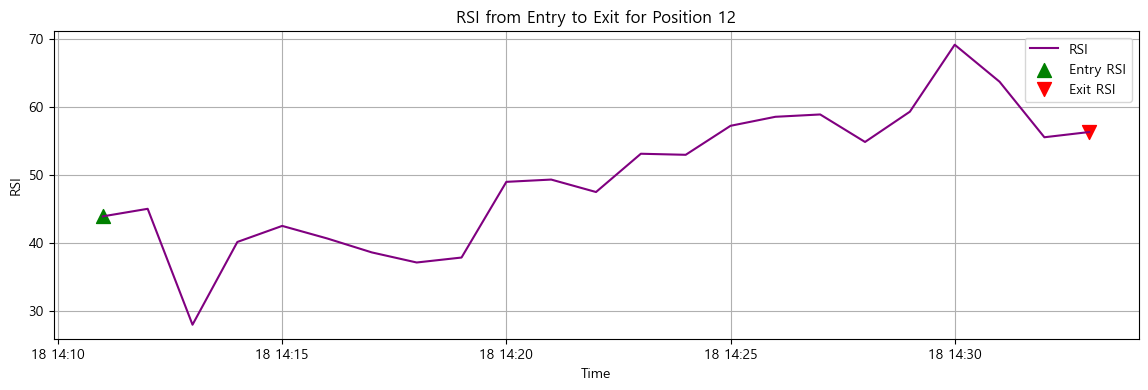

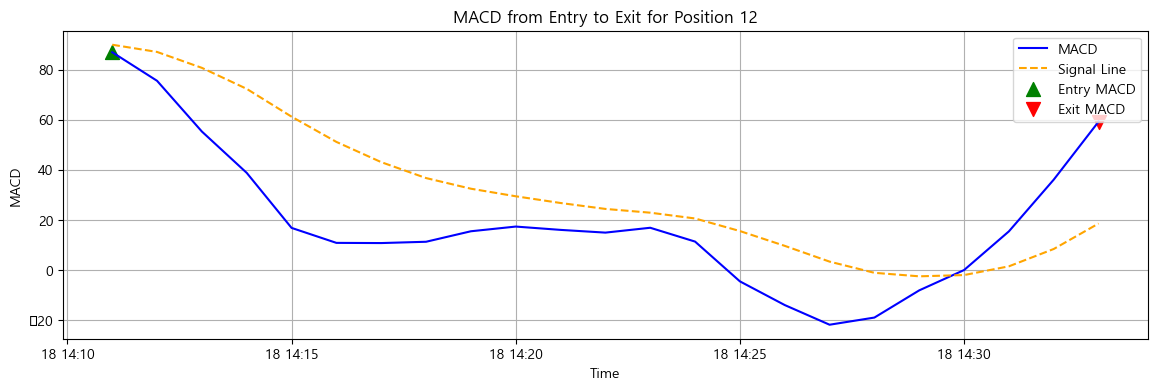

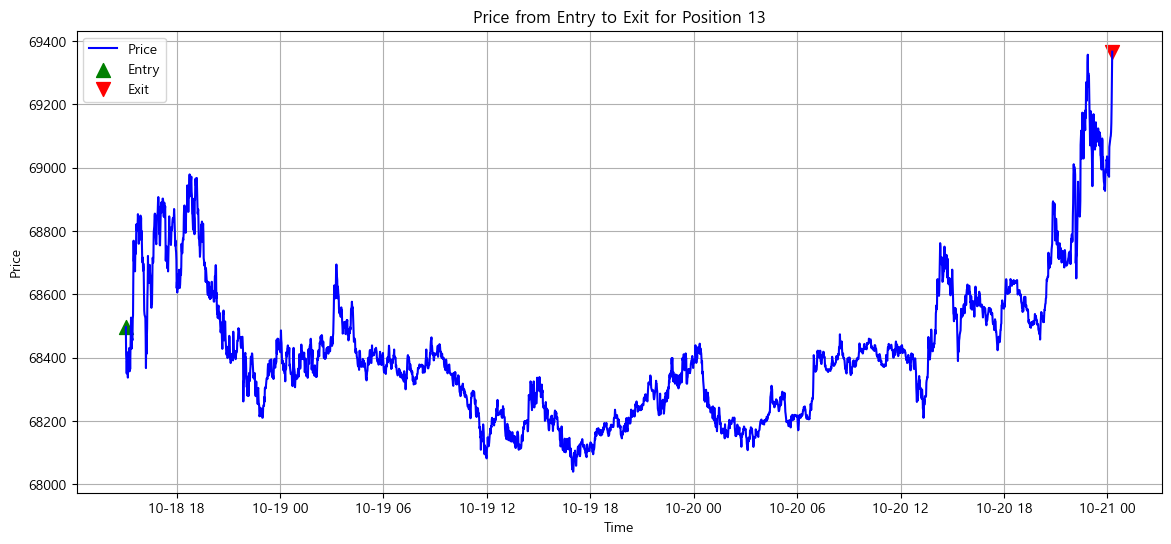

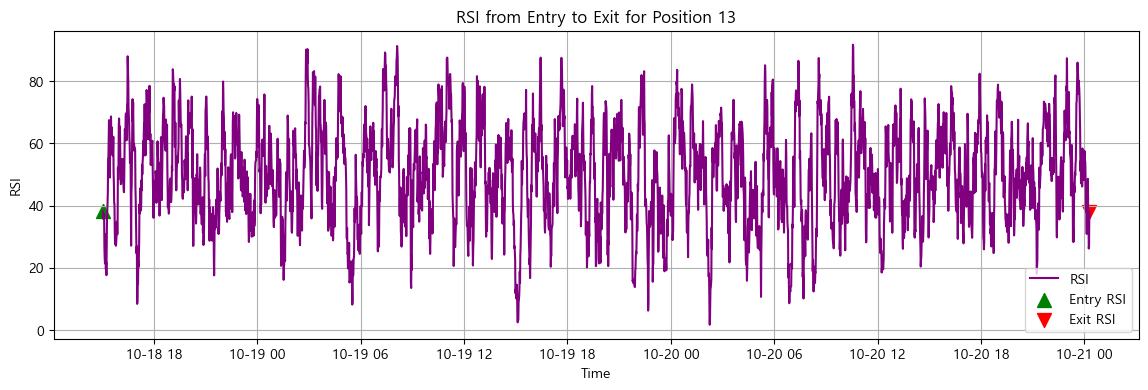

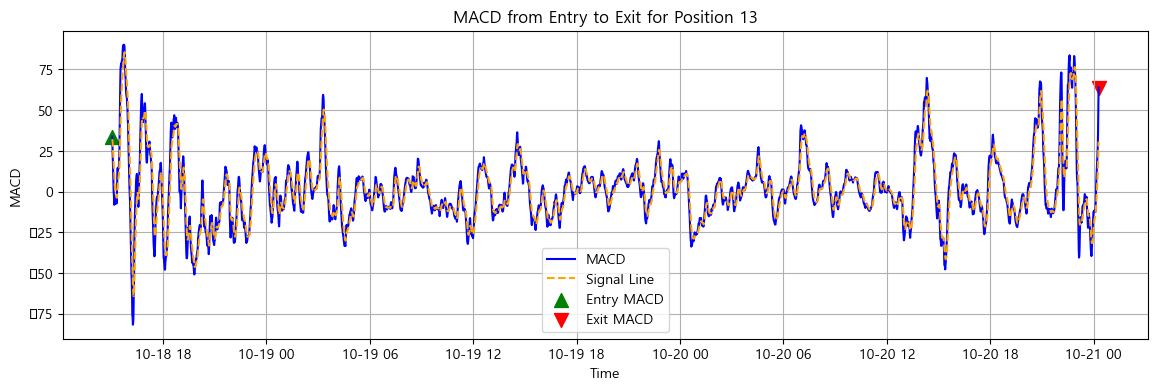

In [19]:
import matplotlib.pyplot as plt



def visualize_entry_exit_series(data, results_df):
    for idx, result in results_df.iterrows():
        # Entry와 Exit 시간 구간 필터링
        entry_time = result['Entry_Time']
        exit_time = result['Exit_Time']
        mask = (data['timestamp'] >= entry_time) & (data['timestamp'] <= exit_time)
        entry_exit_data = data.loc[mask]

        if entry_exit_data.empty:
            continue
        
        # 1. 가격 시계열 시각화
        plt.figure(figsize=(14, 6))
        plt.plot(entry_exit_data['timestamp'], entry_exit_data['close'], label='Price', color='blue')
        plt.scatter(result['Entry_Time'], result['Entry_Price'], color='green', marker='^', s=100, label='Entry')
        plt.scatter(result['Exit_Time'], result['Exit_Price'], color='red', marker='v', s=100, label='Exit')
        plt.title(f'Price from Entry to Exit for Position {idx}')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.show()

        # 2. RSI 시계열 시각화
        plt.figure(figsize=(14, 4))
        plt.plot(entry_exit_data['timestamp'], entry_exit_data['RSI'], label='RSI', color='purple')
        plt.scatter(result['Entry_Time'], result['Entry_RSI'], color='green', marker='^', s=100, label='Entry RSI')
        plt.scatter(result['Exit_Time'], result['Exit_RSI'], color='red', marker='v', s=100, label='Exit RSI')
        plt.title(f'RSI from Entry to Exit for Position {idx}')
        plt.xlabel('Time')
        plt.ylabel('RSI')
        plt.legend()
        plt.grid(True)
        plt.show()

        # 3. MACD 시계열 시각화
        plt.figure(figsize=(14, 4))
        plt.plot(entry_exit_data['timestamp'], entry_exit_data['MACD'], label='MACD', color='blue')
        plt.plot(entry_exit_data['timestamp'], entry_exit_data['Signal_Line'], label='Signal Line', color='orange', linestyle='--')
        plt.scatter(result['Entry_Time'], result['Entry_MACD'], color='green', marker='^', s=100, label='Entry MACD')
        plt.scatter(result['Exit_Time'], result['Exit_MACD'], color='red', marker='v', s=100, label='Exit MACD')
        plt.title(f'MACD from Entry to Exit for Position {idx}')
        plt.xlabel('Time')
        plt.ylabel('MACD')
        plt.legend()
        plt.grid(True)
        plt.show()

# 사용 예시:
# data는 시계열 데이터프레임, results_df는 포지션 결과 데이터프레임
visualize_entry_exit_series(line_data, backtest)


In [21]:
print(backtest)

  Position  Entry_RSI  Exit_RSI  Max_Profit_RSI  Entry_MACD  Exit_MACD  \
0     Long      40.23     57.34           57.34       -3.33      35.24   
1     Long      77.02     50.44           85.67       -8.46     -56.64   
2     Long      24.67     81.01           81.01       27.27      77.88   
3     Long      87.40     53.79           50.53       88.90     -69.69   
4     Long      42.07     75.19           75.19       45.82      57.77   

   Max_Profit_MACD  Entry_Signal_Line  Exit_Signal_Line  \
0            35.24              -7.55             30.26   
1             4.34             -15.54            -44.47   
2            77.88              20.73             52.07   
3            97.06              64.76            -44.79   
4            57.77              38.25             27.00   

   Max_Profit_Signal_Line          Entry_Time  Entry_Price  \
0                   30.26 2024-10-16 05:00:00     66998.02   
1                   -6.07 2024-10-16 06:45:00     67094.87   
2             